## Initial Note 
**Due to complexity and training time, Notebook was created on kaggle - I'm aware of the layout/readibility issues and will address then with further versions of this project.**

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', module='tensorflow')
from tensorflow.config.optimizer import set_experimental_options
set_experimental_options({"layout_optimizer": False})

import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import itertools
import pickle 

# Functions creation

In [2]:
def display_random_images(sample_no, dataset_path):
    # EDA function - displaying sample (random) image per class #max value 7 - as that's the class count
    dataset_name = os.path.basename(dataset_path).replace('_path', '') + ' Dataset'

    # Check if the sample number is greater than the number of subfolders
    subfolders = [f.path for f in os.scandir(dataset_path) if f.is_dir()]
    if sample_no > len(subfolders):
        print(f"Sample number exceeds the number of subfolders. There are only {len(subfolders)} subfolders.")
        return

    # Select random unique subfolders
    selected_subfolders = random.sample(subfolders, sample_no)

    plt.figure(figsize=(15, 5))

    # Add the title (class/emotion/affect) above the images
    plt.suptitle(dataset_name, fontsize=16)
    
    plt.subplots_adjust(top=1.35)  

    # For each selected subfolder, pick a random sample image and display it
    for i, subfolder in enumerate(selected_subfolders):
        # Get all images in the subfolder
        images = [os.path.join(subfolder, img) for img in os.listdir(subfolder) if img.endswith(('.png', '.jpg', '.jpeg'))]
        
        # Pick a random image
        if images:
            random_image_path = random.choice(images)
            image = Image.open(random_image_path)
            
            # Display the image with the label
            plt.subplot(1, sample_no, i + 1)
            plt.imshow(image, cmap='gray')
            plt.title(os.path.basename(subfolder))
            plt.axis('off')
        else:
            print(f"No images found in {subfolder}")

    plt.show()
    

def create_histogram_from_dataset(dataset_path):
    # EDA function - Creation of dataset histogram to showcase the data distribution
    # Additional dictionary to keep the classes coloring constant in each dataset
    color_dict = {
    'disgust': 'green',
    'surprise': 'blue',
    'angry': 'red',
    'anger': 'red',
    'fear': 'purple',
    'sad': 'gray',
    'sadness': 'gray',
    'neutral': 'brown',
    'happy': 'orange'}
    
    # Create a dictionary to hold subfolder names and file counts
    data = {}

    for subfolder in os.scandir(dataset_path):
        if subfolder.is_dir():
            file_count = len([file for file in os.listdir(subfolder.path) if os.path.isfile(os.path.join(subfolder.path, file))])
            data[subfolder.name.lower()] = file_count  # Convert subfolder names to lowercase

    # Create a DataFrame from the dictionary
    df = pd.DataFrame(list(data.items()), columns=['Subfolder', 'FileCount'])

    # Replace 'angry' with 'anger' and 'sadness' with 'sad' in the Subfolder column  =  this change is due to different naming in additional datasets
    df['Subfolder'] = df['Subfolder'].replace({'angry': 'anger', 'sadness': 'sad'})

    df_sorted = df.sort_values(by='FileCount')

    plt.figure(figsize=(10, 6))
    colors = [color_dict.get(subfolder, 'black') for subfolder in df_sorted['Subfolder']]
    bars = plt.bar(df_sorted['Subfolder'], df_sorted['FileCount'], color=colors)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', color='black', fontsize=8)
        
    plt.xticks(rotation=45)
    plt.title('File Distribution in ' + os.path.basename(dataset_path))
    plt.show()
    
    
    
    
    
# Model functions - functions to create 4 models (EfficientNetB0, EfficientNetB3, VGG16 and Custom NN based on manual tuning)

def create_efficientnetb0_model(num_classes):

    model_base_b0 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
        # Freeze all layers except the last 25
    for layer in model_base_b0.layers[:-25]:
        layer.trainable = False
    
    model_name = "EfficientNetB0"

    model_b0 = models.Sequential(name=model_name)
    model_b0.add(model_base_b0)
                 
    # Flattening
    model_b0.add(Flatten())

    # Fully connected layer 1st layer
    model_b0.add(Dense(256))
    model_b0.add(BatchNormalization())
    model_b0.add(Activation('relu'))
    model_b0.add(Dropout(0.25))

    # Fully connected layer 2nd layer
    model_b0.add(Dense(512))
    model_b0.add(BatchNormalization())
    model_b0.add(Activation('relu'))
    model_b0.add(Dropout(0.25))

    
    model_b0.add(Dense(num_classes, activation='softmax'))  
    
    return model_b0

def create_efficientnetb3_model(num_classes):

    model_base_b3 = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    # Freeze all layers except the last 20
    for layer in model_base_b3.layers[:-20]:
        layer.trainable = False
    
    model_name = "EfficientNetB3"

    model_b3 = models.Sequential(name=model_name)
    model_b3.add(model_base_b3)
    
    # Flattening
    model_b3.add(Flatten())

    # Fully connected layer 1st layer
    model_b3.add(Dense(256))
    model_b3.add(BatchNormalization())
    model_b3.add(Activation('relu'))
    model_b3.add(Dropout(0.25))

    # Fully connected layer 2nd layer
    model_b3.add(Dense(512))
    model_b3.add(BatchNormalization())
    model_b3.add(Activation('relu'))
    model_b3.add(Dropout(0.25))
    
    model_b3.add(Dense(num_classes, activation='softmax'))  
    
    return model_b3

def create_vgg_model(num_classes):

    model_base_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    # Freeze all layers except the last 4 convolutional blocks
    for layer in model_base_vgg.layers[:-8]:
        layer.trainable = False
    
    model_name = "VGG"

    model_vgg = models.Sequential(name=model_name)
    model_vgg.add(model_base_vgg)
    
    # Flattening
    model_vgg.add(Flatten()) # Replaced GlobalAveragePooling2D with Flatten

    # Fully connected layer 1st layer
    model_vgg.add(Dense(256))
    model_vgg.add(BatchNormalization())
    model_vgg.add(Activation('relu'))
    model_vgg.add(Dropout(0.25))

    # Fully connected layer 2nd layer
    model_vgg.add(Dense(512))
    model_vgg.add(BatchNormalization())
    model_vgg.add(Activation('relu'))
    model_vgg.add(Dropout(0.25))
    
    model_vgg.add(Dense(num_classes, activation='softmax'))  

    return model_vgg

def create_custom_cnn(num_classes):

    cnn_model = models.Sequential(name="Custom_CNN_Model")

    # 1st Conv L
    cnn_model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 3)))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Dropout(0.25))

    # 2nd Conv L
    cnn_model.add(Conv2D(128, (5, 5), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Dropout(0.25))

    # 3rd Conv L
    cnn_model.add(Conv2D(512, (3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Dropout(0.25))

    # 4th Conv L
    cnn_model.add(Conv2D(512, (3, 3), padding='same'))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(Dropout(0.25))

    # Flattening
    cnn_model.add(Flatten())

    # 1st Fully connected layer
    cnn_model.add(Dense(256))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(Dropout(0.25))

    # 2nd Fully connected layer
    cnn_model.add(Dense(512))
    cnn_model.add(BatchNormalization())
    cnn_model.add(Activation('relu'))
    cnn_model.add(Dropout(0.25))

    # Output layer
    cnn_model.add(Dense(num_classes, activation='softmax'))

    return cnn_model





# Main Train function - compiling the model with given parameters, fixed callbacks (originated from multiple model testing, as best performing)

def compile_and_train_model(model_instance, trainset, testset, epochs, learning_rate, optimizer_class, model_name, optimizer_name):
    # Other parts of the function...
    model_instance.compile(optimizer=optimizer_class(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=METRICS)

    early_stopping = EarlyStopping(monitor='val_F1Score',
                                    mode = 'auto',
                                    min_delta = 0.001,
                                    patience = 10,
                                    baseline = None,
                                    restore_best_weights = True,
                                    verbose = 1)
    
    lr_scheduler = ReduceLROnPlateau(monitor='val_F1Score', 
                                     patience=6, 
                                     verbose=1, 
                                     factor=0.8, 
                                     min_lr=0.00001)
    
    model_checkpoint_filename = f'{model_name}_{optimizer_name}_lr{learning_rate}_best_model.h5'
    model_checkpoint = ModelCheckpoint(model_checkpoint_filename,
                                       monitor='val_F1Score', 
                                       mode='max', 
                                       save_best_only=True,
                                       save_weights_only= False,
                                       perior = 1,
                                       verbose=1)
    
    history = model_instance.fit(trainset,
                        validation_data=testset,
                        steps_per_epoch=trainset.n//trainset.batch_size,
                        epochs=epochs,
                        validation_steps = testset.n//testset.batch_size,
                        callbacks=[early_stopping, lr_scheduler, model_checkpoint])
    
    return history





# MAIN EVALUATION Function
# 3 subplots - loss / acc / precision
# Predictions for whole dataset for classification report - main 'numbers' metric for model


def evaluate_model(model_instance, history):
    plt.figure(figsize=(30, 10)) 

    # Subplot for Loss
    plt.subplot(1, 3, 1)  
    plt.ylabel('Loss', fontsize=16)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    # Subplot for Accuracy
    plt.subplot(1, 3, 2)  
    plt.ylabel('Accuracy', fontsize=16)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')

    # Subplot for Precision
    plt.subplot(1, 3, 3)  # rows, column, position
    plt.ylabel('Precision', fontsize=16)
    plt.plot(history.history['precision'], label='Training Precision')  
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    
    # Predicting the entire dataset
    y_pred = model_instance.predict(testset, steps=len(testset))
    y_result = np.argmax(y_pred, axis=1)


    # Directly extracting labels if possible
    if hasattr(testset, 'classes'):
        y_actual = testset.classes
    else:
        print("Generator does not have 'classes' attribute. Ensure labels are correctly extracted.")
        return


    # Classification report
    print("Classification report")
    print(classification_report(y_actual, y_result))
    
    
    
    
    
    
# Function to start other predefined functions
    
def test_model(model_instance, optimizer_class, learning_rate, model_name, optimizer_name):
    model_instance.summary()
    history = compile_and_train_model(model_instance, trainset, testset, epochs, learning_rate, optimizer_class, model_name, optimizer_name)
    evaluate_model(model_instance, history)
    
    
      

# Visual representation - confusion matrix
    
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

#report to compare models, class report + visual CM    
    
def generate_reports(model, testset): 
    # Get predictions
    y_pred = model.predict(testset)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Extract actual labels from testset
    if hasattr(testset, 'classes'):
        y_true = testset.classes
    else:
        print("Generator does not have 'classes' attribute. Ensure labels are correctly extracted.")
        return

    # Validate length of predictions and actual labels
    if len(y_pred_classes) != len(y_true):
        print("Warning: Length mismatch between predictions and actual labels.")
        print("Length of predictions:", len(y_pred_classes), "Length of actual labels:", len(y_true))
        return

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Plot graphical confusion matrix
    class_labels = list(testset.class_indices.keys())  # Extract class labels from testset
    plot_confusion_matrix(cm, classes=class_labels, title=f'Confusion Matrix for {model.name}')

    # Classification report
    cr = classification_report(y_true, y_pred_classes, target_names=class_labels)
    print(f"Classification Report for {model.name}:\n", cr)
    

#Visual testing of models - printing images with their actual label and predicted label by model
#by editing model - possible to check all of them, by editing validset - possible to check compared to other datasets
    
def display_predictions(model_to_test, validset_to_test):
    test_images, test_labels = next(validset_to_test)
    preds = model_to_test.predict(test_images)
    idx = np.argmax(preds, axis=1)
    test_labels = np.argmax(test_labels, axis=1)
    idx = idx.reshape((-1, 1))
    test_labels = np.reshape(test_labels, (len(test_labels), 1))

    print('Correct prediction:', np.sum((test_labels == idx)*1) / len(test_labels))

    def compare(index, class_dictionary):
        if isinstance(index, np.ndarray):
            index = index[0]
        return class_dictionary.get(index, "Unknown")

    def dif(test_label, pred_idx, class_dictionary):
        test_label = test_label[0] if isinstance(test_label, np.ndarray) else test_label
        pred_idx = pred_idx[0] if isinstance(pred_idx, np.ndarray) else pred_idx

        actual_label = class_dictionary.get(test_label, "Unknown")
        predicted_label = class_dictionary.get(pred_idx, "Unknown")
        return predicted_label, actual_label

    class_dictionary = {v: k for k, v in trainset.class_indices.items()}

    fig = plt.figure(figsize=(20, 20))
    for j in range(20):
        ax = plt.subplot(4, 5, j + 1)
        ax.imshow(test_images[j])
        ax.set_xticks([])
        ax.set_yticks([])

        test_label = test_labels[j][0] if isinstance(test_labels[j], np.ndarray) else test_labels[j]
        pred_idx = idx[j][0] if isinstance(idx[j], np.ndarray) else idx[j]

        if test_label == pred_idx:
            ax.spines['top'].set_color('green')
            ax.spines['bottom'].set_color('green')
            ax.spines['left'].set_color('green')
            ax.spines['right'].set_color('green')
            ax.set_title(compare(pred_idx, class_dictionary), color='green', fontsize=12)
        else:
            ax.spines['top'].set_color('red')
            ax.spines['bottom'].set_color('red')
            ax.spines['left'].set_color('red')
            ax.spines['right'].set_color('red')
            pred_label, actual_label = dif(test_label, pred_idx, class_dictionary)
            ax.set_title(f'Pred: {pred_label} | Act: {actual_label}', color='red', fontsize=12)

    plt.tight_layout()
    plt.show()


# Data Loading and Exploration

The first step in our project involves loading and exploring three key datasets: FER2013, FER2013balanced, and CK+48. Each of these datasets plays a crucial role in training and testing our models. FER2013 is primarily used for both training and testing purposes, while FER2013balanced and CK+48 are employed for additional testing to evaluate the robustness and generalizability of our models.

All three datasets are organized in a similar structure, consisting of folders named according to the labeled emotion classes (e.g., happiness, sadness, anger, etc.), with corresponding images contained within. This uniform structure facilitates a streamlined loading process and initial exploration.

As part of our exploration, we will display sample images from each class across the datasets. This visual inspection not only aids in understanding the variety and nature of the data but also allows us to spot potential anomalies. A noteworthy aspect of the FER2013 dataset, in particular, is the presence of potentially mislabeled images. Emotion classification, even for humans, can be subjective and challenging, with certain emotions being particularly difficult to distinguish. This inherent ambiguity suggests that perfect classification accuracy might be unattainable and sets a realistic expectation for the performance of our models. Our exploration, thus, serves as an essential precursor to developing a nuanced understanding of the data and the challenges it presents for emotion recognition.

1. FER2013 Dataset:

* Description: The Facial Expression Recognition 2013 (FER2013) dataset was introduced in the ICML 2013 Challenges in Representation Learning. It is one of the most widely used datasets in the field of emotion recognition.
* Content: The dataset contains 35,887 grayscale images of human faces, each with a size of 48x48 pixels.
* Emotion Classes: It includes seven emotion categories - anger, disgust, fear, happiness, sadness, surprise, and neutral.
* Usage: In this project, FER2013 is used for both training and testing the models.
* Challenges: One notable challenge is the presence of potentially mislabeled images, reflecting the subjective nature of human emotions.

2. FER2013balanced Dataset:

* Description: This is a modified version of the FER2013 dataset, structured to address the issue of class imbalance found in the original dataset.
* Content: Like FER2013, it consists of grayscale images of faces categorized by emotions. However, the distribution of images across different emotion classes is more balanced.
* Emotion Classes: It covers the same seven categories as FER2013.
* Usage: FER2013balanced is primarily used for testing to evaluate the model's performance in a more balanced scenario.
* Advantages: By providing a balanced number of samples for each emotion, it allows for a more equitable assessment of model performance across different emotion classes.

3. CK+48 Dataset:

* Description: The Extended Cohn-Kanade (CK+) dataset is another popular dataset for facial expression recognition, known for its high-quality images.
* Content: The CK+48 version contains cropped images of faces from the CK+ dataset, resized to 48x48 pixels in grayscale.
* Emotion Classes: It covers the same seven categories, 1 category vary from FER2013 models.
* Usage: In this project, CK+48 is used for testing to assess the generalizability of the models to different data sources.
* Advantages: The high-quality and well-labeled nature of the images in CK+48 make it an excellent dataset for validating the effectiveness of emotion recognition models.


In [3]:
fer2013train_path = '/kaggle/input/fer2013/train'
fer2013test_path = '/kaggle/input/fer2013/test'
fer2013p_path = '/kaggle/input/fer2013plus-cleaned-augm-balanced/ONE-SET'
ckplus_path = '/kaggle/input/ckplus/CK+48'

# Sample Image Analysis with a Focus on Data Quality and Label Accuracy

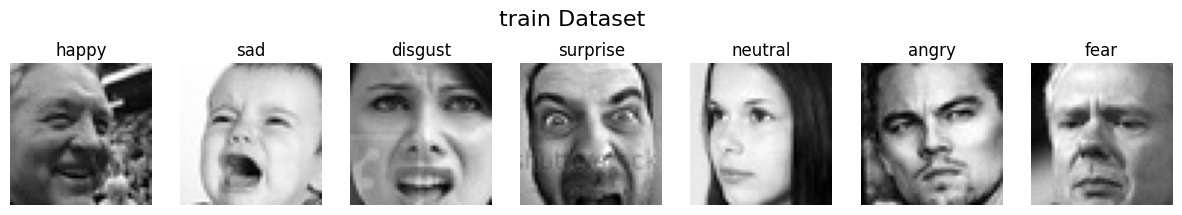

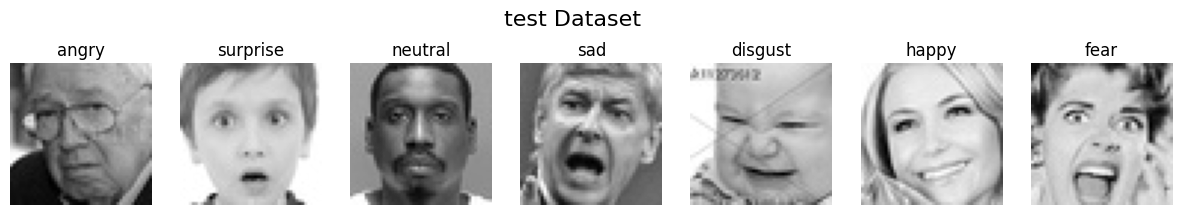

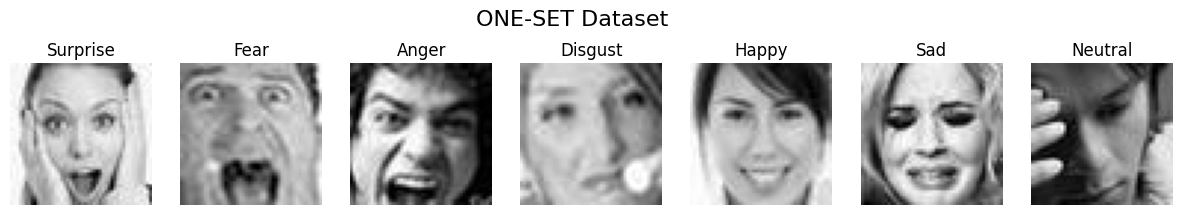

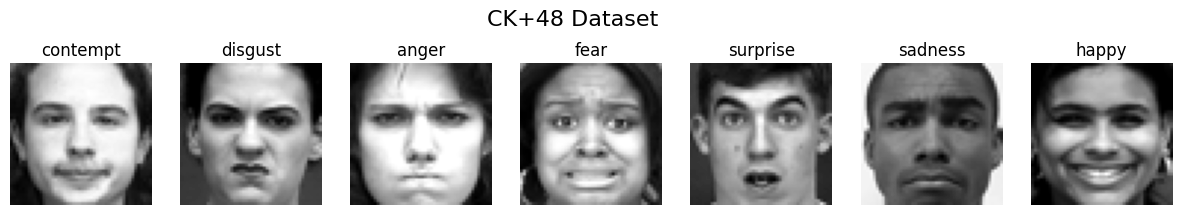

In [4]:
display_random_images(7, fer2013train_path)
display_random_images(7, fer2013test_path)
display_random_images(7, fer2013p_path)
display_random_images(7, ckplus_path)

### FER2013 and FER2013balanced Datasets:
In examining seven representative samples from the FER2013 and FER2013balanced datasets, various issues with image quality and labeling accuracy were observed:

* Variable Image Quality: The pictures in these datasets are not of uniform quality, exhibiting variations in clarity and resolution, which could affect model performance.

* Watermarks and Artifacts: Some images contain watermarks and other artifacts, introducing noise into the data that could complicate emotion recognition tasks.

* Tilted and Cropped Faces: Faces are often tilted or partially cropped, leading to inconsistencies in face orientation and framing. This poses challenges, especially for models that rely on spatial relationships of facial features.

* Objects Covering Faces: In some images, objects obscure parts of the face, making it difficult for models to accurately interpret facial expressions.

* Mislabeled Entries: Interestingly, our random sampling from these datasets fortuitously revealed mislabeled entries. This demonstrates the subjectivity and complexity in classifying emotions, even for humans. Some emotions can be hard to distinguish, and this inherent ambiguity in the data sets a realistic expectation for the accuracy of any emotion recognition model.

### CK+48 Dataset:
In contrast, the CK+48 dataset showed a higher standard in terms of image quality:

* Consistent High Quality: The images are clearer and better lit, offering more consistency.

* Well-Centered Faces: Faces are generally well-centered, reducing variability in face positioning and aiding the training process.

* Uniform Framing: The consistent framing of images allows models to focus on learning facial expressions without the need to adjust for varying compositions.

### Conclusion
These findings underscore the importance of considering both data quality and label accuracy when training emotion recognition models. The FER datasets, despite their real-world complexity and imperfections, provide valuable insights into the challenges of emotion AI. The presence of mislabeled entries, in particular, highlights the need for careful data preprocessing and robust model validation. Meanwhile, the CK+48 dataset, with its higher quality images and consistent framing, serves as a solid benchmark for testing model performance under more controlled conditions. This diverse dataset collection thus offers a comprehensive platform for developing and evaluating robust and adaptable emotion recognition models.

# Distribution and Decision Rationale Regarding Data Balancing

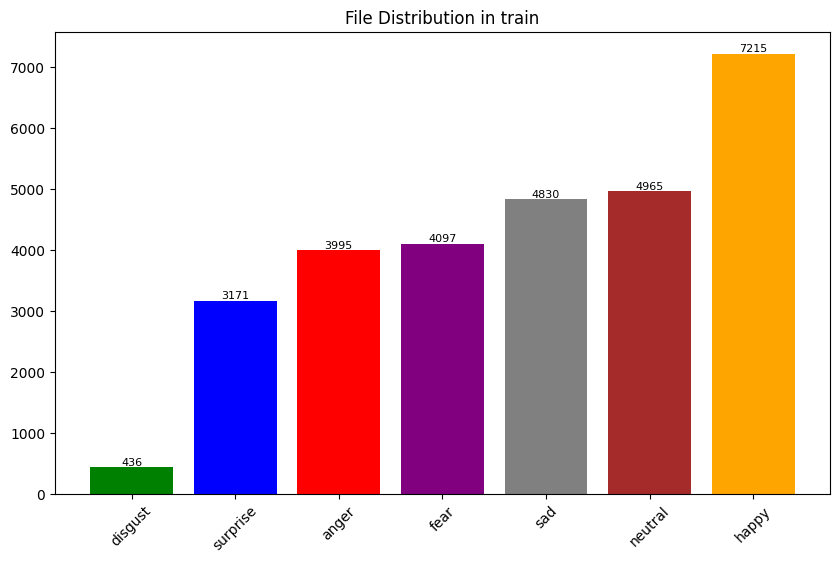

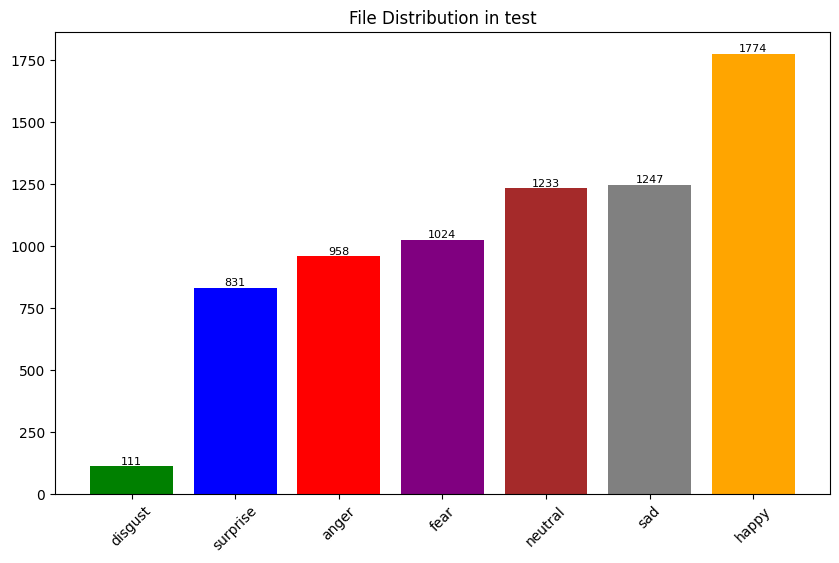

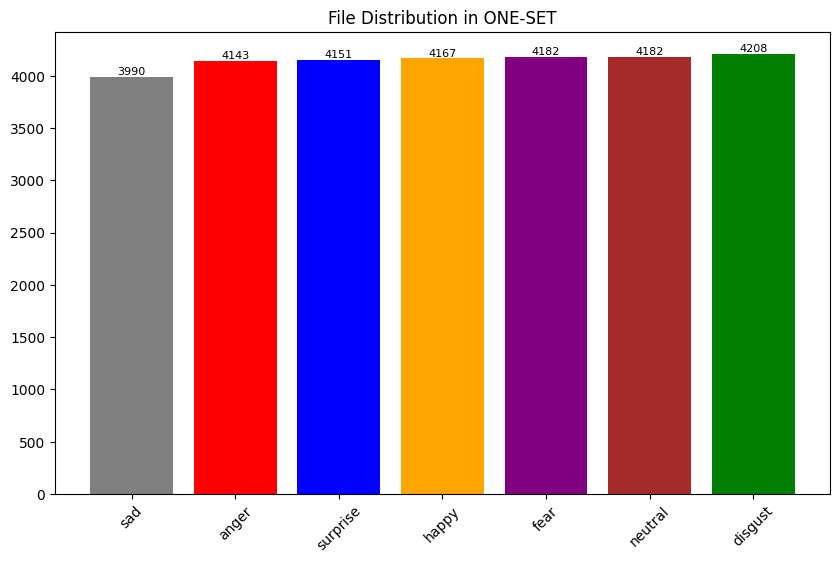

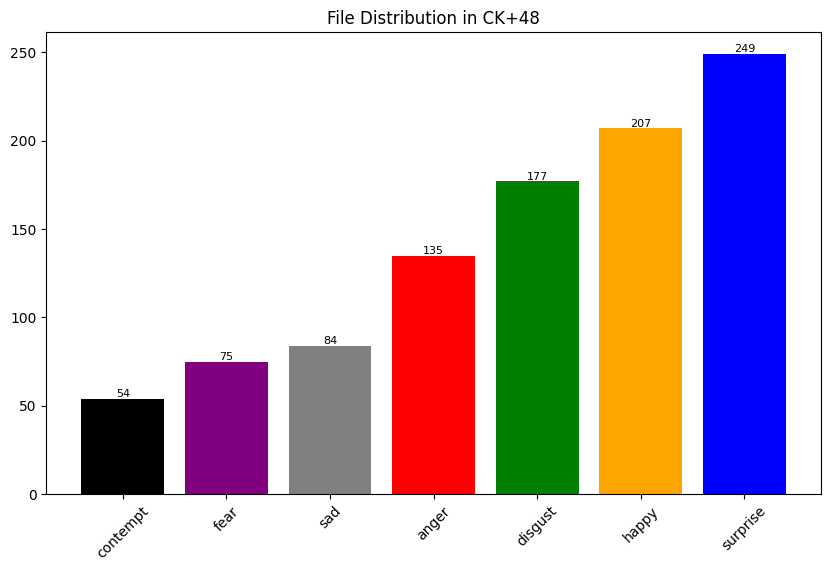

In [5]:
create_histogram_from_dataset(fer2013train_path)
create_histogram_from_dataset(fer2013test_path)
create_histogram_from_dataset(fer2013p_path)
create_histogram_from_dataset(ckplus_path)

## Distribution in Datasets
Analyzing the class distribution across our datasets reveals significant imbalances:

1. **FER2013:** This dataset exhibits a pronounced class imbalance. The largest class has 7,215 images, which is about 15 times larger than the smallest class with only 436 images. Such disparities pose a challenge for model training, as they can lead to biases towards more represented classes.

2. **FER2013balanced:** As the name suggests, this version of the dataset has been adjusted to have almost equal quantities of images per class. This balance provides an opportunity to assess model performance in a more equitable environment.

3. **CK+48:** This dataset also shows class imbalances, although to a lesser extent than FER2013. The largest class is approximately 5 times bigger than the smallest one.\


**Rationale for Not Using Undersampling/Oversampling**\
Initially, various techniques like undersampling, oversampling, and Synthetic Minority Over-sampling Technique (SMOTE) were tested on the FER2013 training data to address these imbalances. However, the results were not entirely satisfactory:

* Limited Improvement in Minority Classes: While these techniques sometimes slightly improved metrics for classes with lower representation, the overall enhancement was not substantial enough to justify their use.

* Negative Impact on Other Classes: More critically, efforts to balance the classes often negatively affected the model's performance in other areas. This trade-off indicated that these balancing techniques were not the most effective approach for this particular dataset and problem.\

**Decision to Use Raw Data with Data Augmentation**\
Given these observations, the decision was made to work with the datasets in their raw, unbalanced form for training purposes. To mitigate the impact of class imbalance, data augmentation techniques are applied to the training set. Data augmentation involves artificially expanding the dataset by creating modified versions of existing images, such as through rotations, scaling, or color adjustments. This approach aims to:

* Enhance Model Robustness: By exposing the model to a wider variety of data representations, it becomes more robust and less likely to overfit to the more represented classes.

* Preserve Data Integrity: Working with the raw data ensures that the original distribution and characteristics of the datasets are maintained, providing a more authentic environment for training and testing the models.\

### Conclusion
The decision to retain the original class distribution and rely on data augmentation reflects a careful consideration of the datasets' characteristics and the outcomes of preliminary experiments. This approach is aimed at developing models that are both robust and capable of handling real-world data imbalances, while also acknowledging the limitations of conventional class balancing techniques in this specific context.

Creation of DataGenerators - train set with augumentations to increase the complexity to train the model, basic arguments (no finetuning here) used
additional datagens for new datasets

# Data Preprocessing and Generation Setup

In [6]:
# # ImageDataGenerator for validation set without augmentation, just normalization

f_train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    rescale=1./255)

f_test_datagen = ImageDataGenerator(
    rescale=1./255)

fp_test_datagen = ImageDataGenerator(
    rescale=1./255)

ck_test_datagen = ImageDataGenerator(
    rescale=1./255)

In [7]:
# Data generators () 
trainset = f_train_datagen.flow_from_directory(
    directory=fer2013train_path,
    target_size=(48, 48),
    batch_size=128,
    class_mode='categorical',
    shuffle=True)

testset = f_test_datagen.flow_from_directory(
    directory=fer2013test_path,
    target_size=(48, 48),
    batch_size=128,
    class_mode='categorical',
    shuffle=False)

testset_shuffled = f_test_datagen.flow_from_directory(
    directory=fer2013test_path,
    target_size=(48, 48),
    batch_size=128,
    class_mode='categorical',
    shuffle=True)

testset_ferplus = fp_test_datagen.flow_from_directory(
    directory=fer2013p_path,
    target_size=(48, 48),
    batch_size=128,
    class_mode='categorical',
    shuffle=True)

testset_ck = ck_test_datagen.flow_from_directory(
    directory=ckplus_path,
    target_size=(48, 48),
    batch_size=128,
    class_mode='categorical',
    shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 29023 images belonging to 7 classes.
Found 981 images belonging to 7 classes.


**Training Data Augmentation**
1. Generator (f_train_datagen): Applies rotation, zoom, shift, shear, and horizontal flip transformations, along with pixel value rescaling (normalization) to enhance model generalization.
1. Batch Size: 128
1. Target Size: 48x48 pixels
1. Shuffle: Enabled for diversity in training batches.
**Test Data Normalization**
* Generators (f_test_datagen, fp_test_datagen, ck_test_datagen): Only perform pixel value rescaling for normalization, without augmentation.
* Batch Size: 128
* Target Size: 48x48 pixels
* Shuffle: Disabled for consistent evaluation, except in testset_shuffled for additional robustness testing.

**Data Loaders**
* Loaders: Separate loaders (trainset, testset, testset_ferplus, testset_ck, testset_shuffled) for different datasets (FER2013, FER2013Plus, CK+48) and test conditions.
* Class Mode: Categorical for multi-class classification.\\

**Summary**\
This setup ensures that the models are trained on augmented data for better generalization and tested on consistent, normalized data for accurate performance evaluation. The additional shuffled test set provides insights into the model's stability under varied data order.

# Model Selection and Comparison in the Project

After extensive testing, the project focuses on comparing **three models**:

* 1 Custom Models: Tailored neural networks specifically designed for this project.
* 1 Variants of EfficientNetB3: Known for their efficiency, chosen with variations in learning rates or optimizers.
* 1 Variants of VGG16: Selected for their depth and effectiveness in image classification, each with minor differences in learning rate or optimizer.

*These variants allow for an assessment of the impact of hyperparameter (very small adjustments, as 3 preselected models are already selected from over 200+ models [over 60 hours of model training] variations tested) on model performance.* 

In [8]:
cnn = create_custom_cnn(7)
# cnn_2 = create_custom_cnn(7)
eb0 = create_efficientnetb0_model(7)
# eb0_2 = create_efficientnetb0_model(7)
# eb3 = create_efficientnetb3_model(7)
# eb3_2 = create_efficientnetb3_model(7)
vgg = create_vgg_model(7)
# vgg_2 = create_vgg_model(7)

58889256/58889256 [==============================] - 2s 0us/step


### Advantages of Using Pretrained Models
**Pretrained models offer several benefits:**

* Rich Feature Learning: They have been trained on large datasets like ImageNet, learning diverse and complex features applicable to various tasks, including emotion recognition.
* Efficiency: Saves time and resources as these models come with pre-learned weights, reducing the need for training from scratch.
* Proven Track Record: Models like EfficientNet and VGG16 are renowned for their high performance in image classification.


**Pretrained Models and Further Information**

**1. EfficientNet Models**:

Overview: EfficientNets are a series of models (B0, B1, B2, B3, etc.) designed for better accuracy with fewer parameters.
Details and Documentation: More information can be found on [TensorFlow's EfficientNet guide](https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetB0) and [EfficientNet paper](https://arxiv.org/abs/1905.11946)

**2. VGG16**:

Overview: A deep convolutional neural network with 16 layers, known for its simplicity and depth.
Details and Documentation: Additional details are available on [VGG16 in Keras](https://keras.io/api/applications/vgg/) and the [VGG16 paper](https://arxiv.org/abs/1409.1556).

### Conclusion
The use of pretrained models like EfficientNet and VGG16, alongside custom-designed networks, provides a robust and comprehensive approach to facial emotion recognition in this project. Their proven capabilities in feature extraction and classification make them ideal candidates for this model training.

# Understanding Metrics in Multi-Class Models

Metrics are essential tools for evaluating the performance of machine learning models. They provide quantitative measurements of various aspects like accuracy, precision, recall, and more. In this project, a custom F1 Score class and a comprehensive list of metrics are used for model evaluation:

**Custom F1 Score Class**
* Purpose: The F1 Score is a harmonic mean of precision and recall, providing a balance between these two metrics. It is especially useful in cases where we need to consider both false positives and false negatives.
* Implementation: The custom F1 Score class in TensorFlow calculates precision and recall and then computes the F1 Score.

**Metrics List for Evaluation**
* Included Metrics: Binary Accuracy, Precision, Recall, AUC (Area Under the Curve), and the custom F1 Score.
* Role: These metrics collectively offer a multi-faceted view of the model's performance, from general accuracy to the balance between precision and recall.


### The Challenge with Multi-Class Models
In the context of a 7-class model like the one in this project, interpreting these metrics requires a deeper understanding:

* Beyond Simple Accuracy: For multi-class models, looking solely at metrics like accuracy or F1 Score can be misleading. These numbers might not fully capture the model's performance across all classes, especially in imbalanced datasets.

* Understanding Class-Specific Performance: It is crucial to delve into class-specific metrics. This involves examining how well the model performs for each individual class, which can reveal biases or weaknesses in certain areas.

* Comprehensive Evaluation: A model must be evaluated on how well it balances precision and recall across all classes, not just its overall accuracy. This is particularly important in applications like emotion recognition, where each class (emotion) holds equal importance.

### Conclusion
For the emotion recognition project, while metrics like accuracy, precision, recall, AUC, and F1 Score are necessary for a basic assessment, a more nuanced interpretation is required. Understanding the performance on a class-by-class basis and considering the balance between different types of errors are key to determining whether the model can be considered truly effective and usable. This comprehensive approach to evaluation ensures that the final model is robust, fair, and practical for real-world applications.

In [9]:
# Custom F1 Score - Class (Metric) for TF  ### code source: github
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [10]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      F1Score()]

# Training Models in the Emotion Recognition Project

### Selection Process for Final Models
The project arrived at a final selection of three models to be trained through a rigorous process:

* Tested Parameters: Various combinations of learning rates (0.01, 0.001, 0.0001, 0.0005), dropout rates (0.2, 0.25, 0.3), optimizers (Nadam, Adam, SGD, RMSprop), and epoch ranges (15-45) were tested.
* Number of Classes: Consistent across all models, there are 7 classes representing different emotions.
* Custom CNN Modifications: The custom CNN underwent extensive modifications to optimize its architecture.
* Pretrained Model Exploration: Various pre-trained models were explored, including EfficientNetB0 to B6 (excluding B7), ResNet models, and VGG. The final selection of VGG, EfficientNetB3 and custom model was based on their performance and processing speed.

### Additional Steps for Pretrained Models
* Limited Trainability: All pre-trained models have adjusted the amount of frozen layers. This means not all layers in these models are involved in the training process.
* Uniform Layer Addition: For both custom and pre-trained models, the following layers were added post the base model:\
Flatten(): To convert the output of the convolutional layers to a format suitable for the dense layers.\
Dense(256), BatchNormalization(), Activation('relu'), Dropout(0.25): A dense layer followed by batch normalisation, ReLU activation, and dropout.\
Dense(512), BatchNormalization(), Activation('relu'), Dropout(0.25): Another dense layer setup similar to the above.\
Dense(num_classes, activation='softmax'): The final output layer with a softmax activation function for multi-class classification.

### Custom CNN Structure
* Layer Details: The custom CNN has 4 convolutional layers, each followed by the same sequence of flattening and connected layers as the other models.

### Rationale Behind Configurations
* Parameter Selection: The choice of dense and dropout parameters, and the overall model structure, was informed by extensive training trials and methodologies found in existing literature and online resources.

### Conclusion
The final set of six models in this project represents a culmination of thorough experimentation and optimization. By testing a wide range of parameters and configurations, the project has identified models and setups that offer an effective balance between accuracy and computational efficiency. The approach ensures that the models are not only well-suited for the task of emotion recognition but are also grounded in practical and tested machine learning practices.

In [11]:
epochs = 65 # numbered lowered due to computing power / resources

models_config = {
     'cnn': {'RMSprop': [0.0001]},
#    'cnn_2': {'RMSprop': [0.0005]},
     'eb0': {'Adam': [0.001]},
#    'eb0_2': {'SGD': [0.0001]},
#    'eb3': {'RMSprop': [0.001]},
#     'eb3_2': {'RMSprop': [0.0005]},
     'vgg': {'RMSprop': [0.001]},
#    'vgg_2': {'SGD': [0.0005]}
}

### Due to time limitations - 3 models were selected for final training. Initially, all 8 models were tested, 
### and the optimisers and LR were adjusted, however due to computing power/resources only 10-15 epochs were being used in tests.

model_instances = {
    'cnn': cnn,
   # 'cnn_2': cnn_2,
    'eb0': eb0,
   # 'eb0_2': eb0_2,
   # 'eb3': eb3,
   # 'eb3_2': eb3_2,
    'vgg': vgg,
   # 'vgg_2': vgg_2
}

optimizers_dict = {
    'RMSprop': tf.keras.optimizers.RMSprop,
    'SGD': tf.keras.optimizers.SGD,
    'Adam': tf.keras.optimizers.Adam
}

Model: cnn, Optimizer: RMSprop, Learning Rate: 0.0001
Model: "Custom_CNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                              

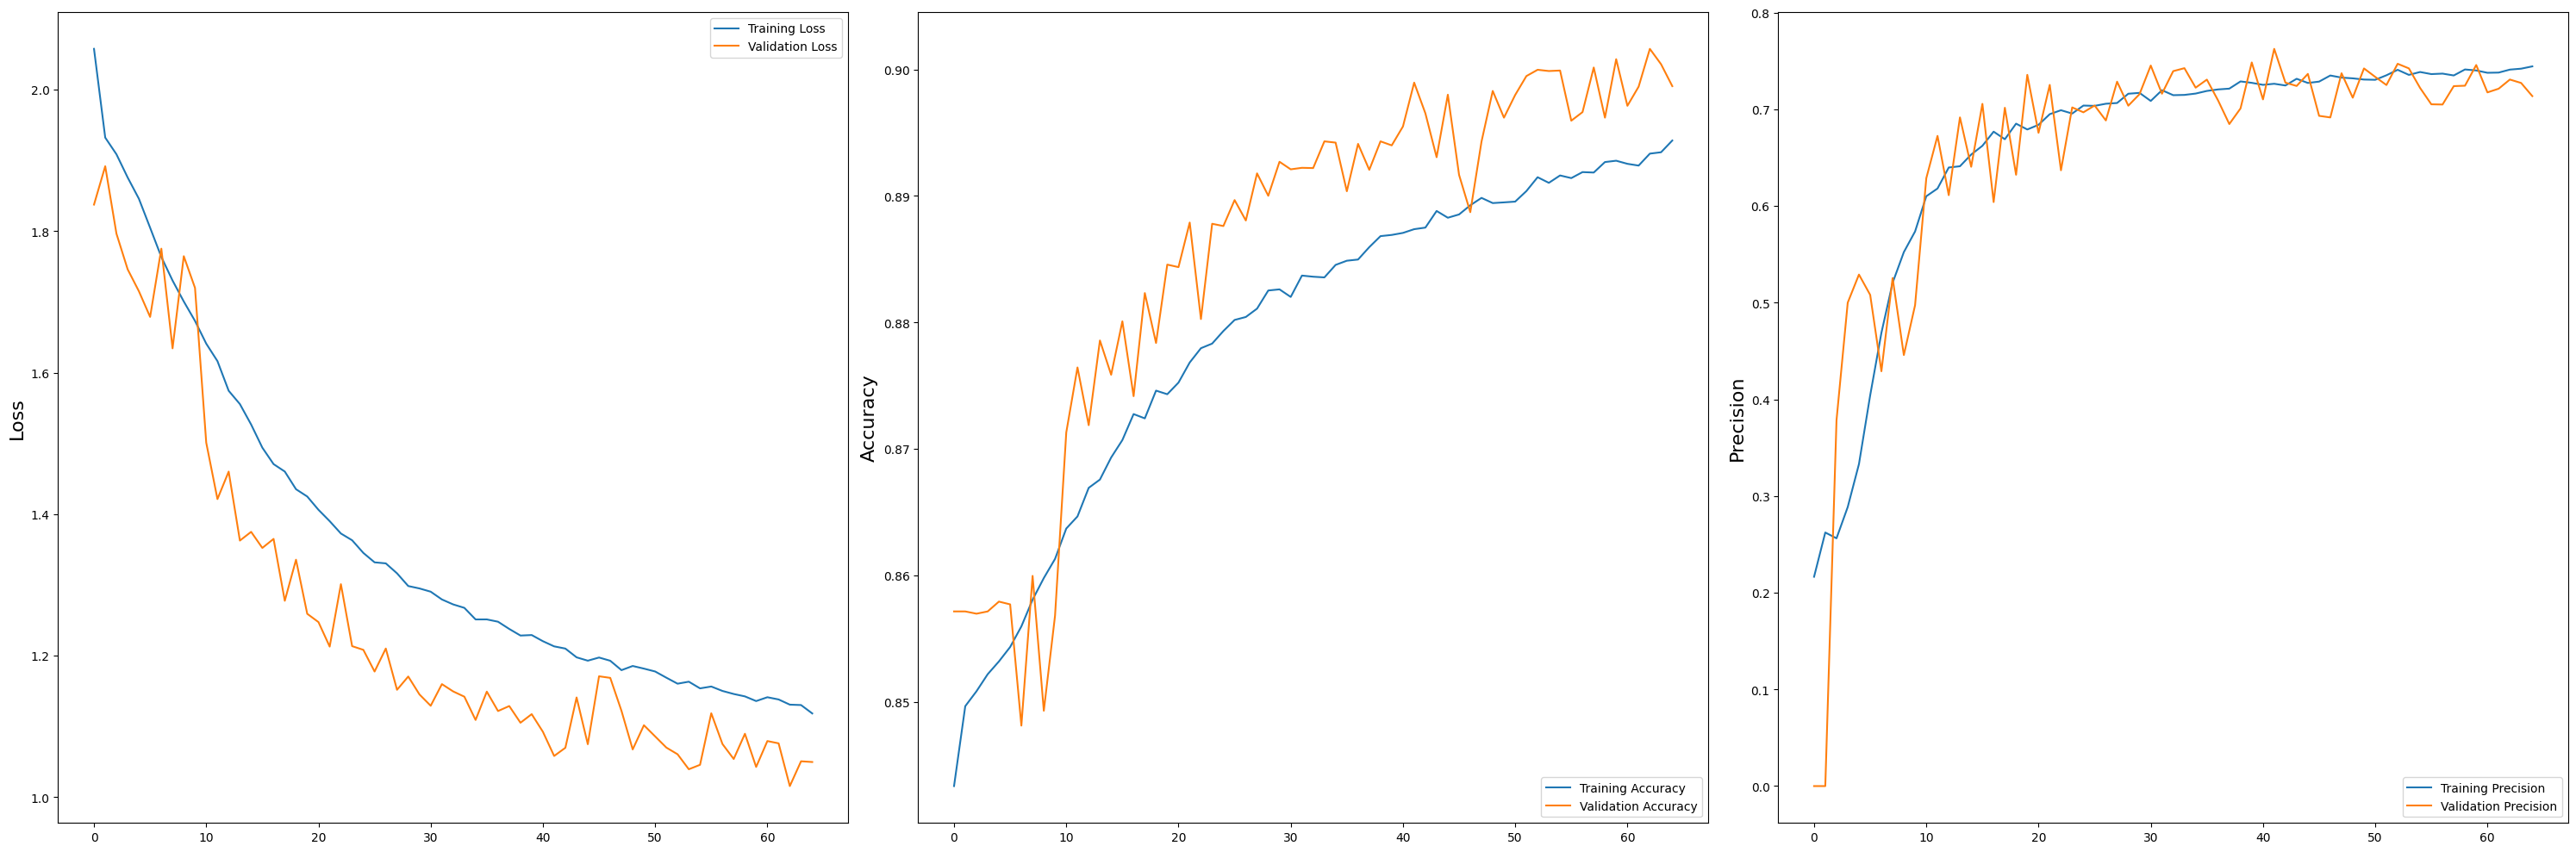

57/57 [==============================] - 7s 114ms/step
Classification report
              precision    recall  f1-score   support

           0       0.56      0.49      0.52       958
           1       0.43      0.27      0.33       111
           2       0.62      0.17      0.26      1024
           3       0.83      0.85      0.84      1774
           4       0.43      0.80      0.56      1233
           5       0.50      0.42      0.45      1247
           6       0.75      0.76      0.75       831

    accuracy                           0.60      7178
   macro avg       0.59      0.54      0.53      7178
weighted avg       0.62      0.60      0.58      7178

Model cnn saved at /kaggle/working/cnn
Model: eb0, Optimizer: Adam, Learning Rate: 0.001
Model: "EfficientNetB0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 2, 2, 1280)        4049571   
 )             

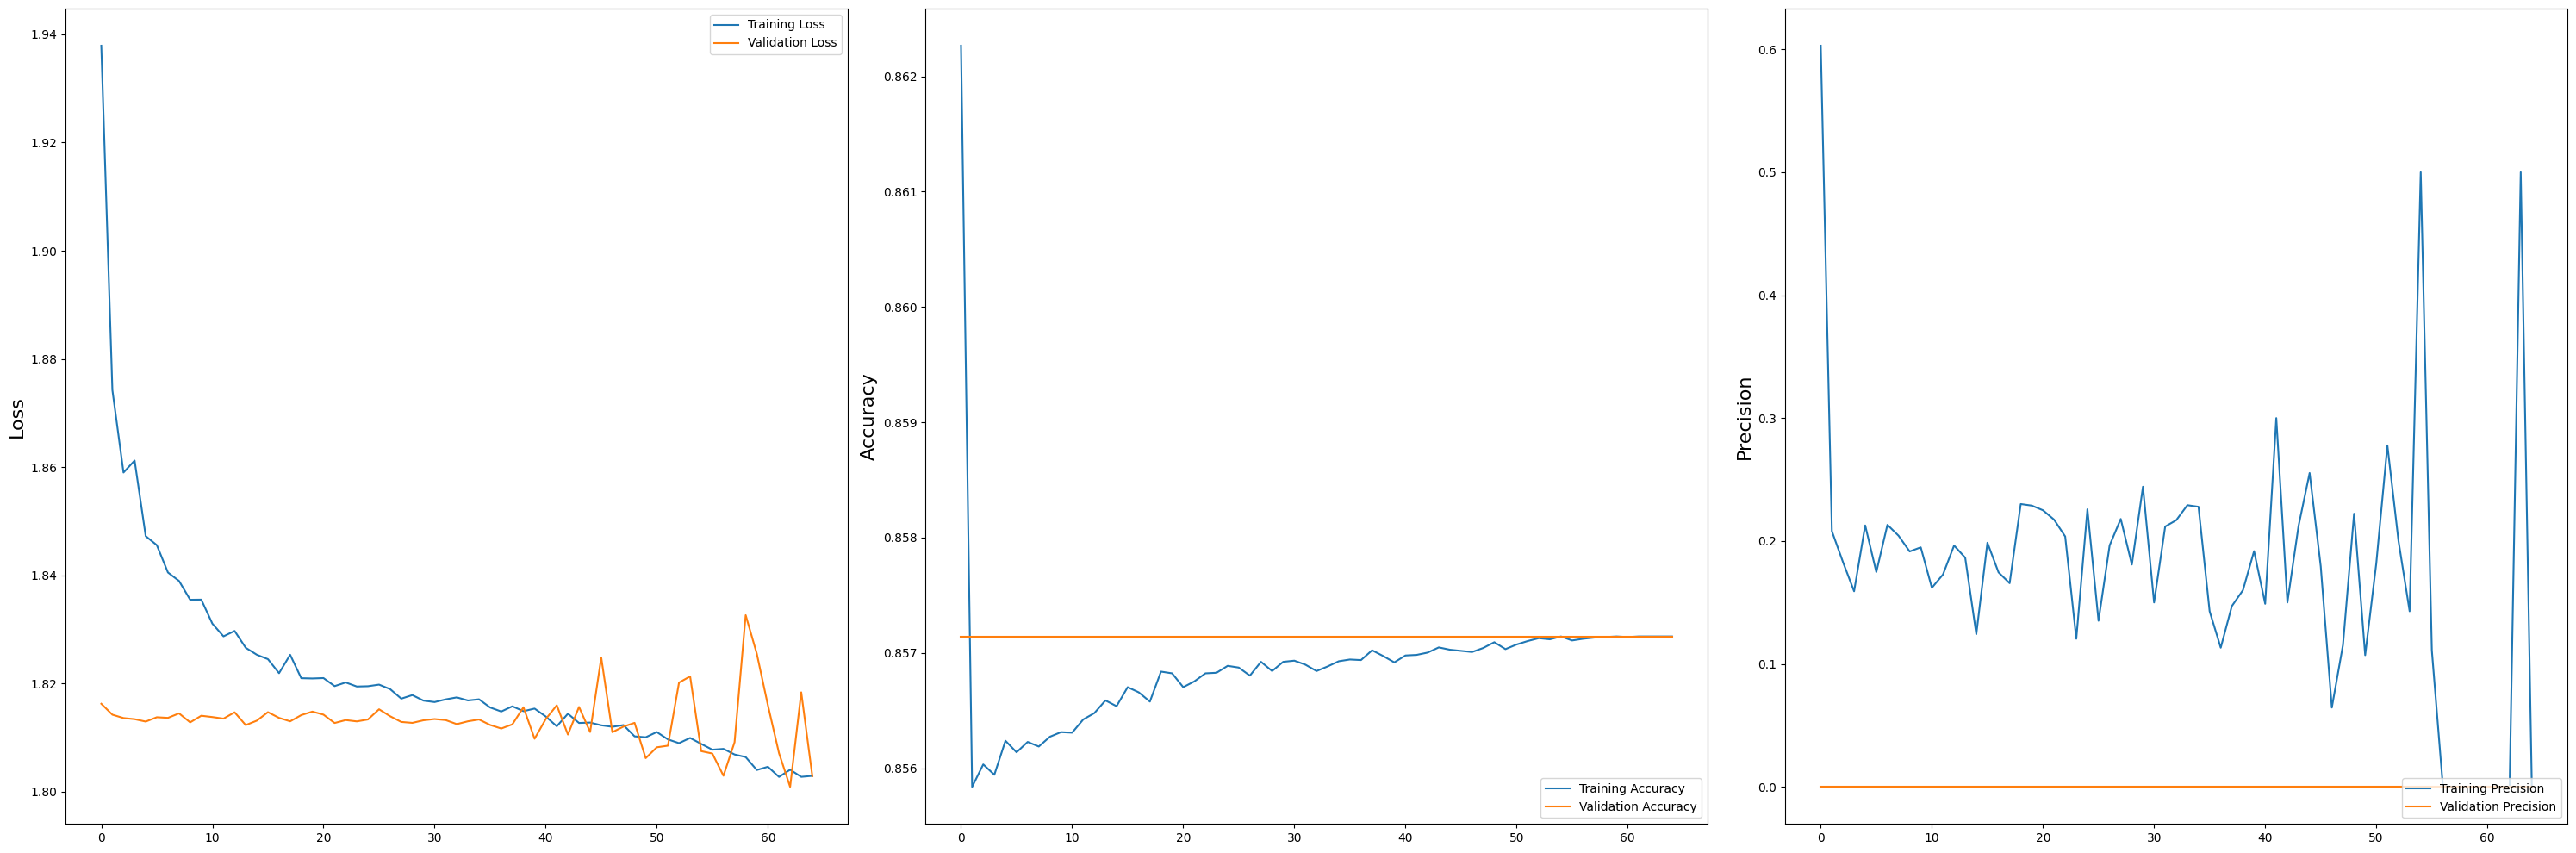

57/57 [==============================] - 9s 121ms/step
Classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       958
           1       0.00      0.00      0.00       111
           2       0.00      0.00      0.00      1024
           3       0.25      1.00      0.40      1774
           4       0.00      0.00      0.00      1233
           5       0.00      0.00      0.00      1247
           6       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178

Model eb0 saved at /kaggle/working/eb0
Model: vgg, Optimizer: RMSprop, Learning Rate: 0.001
Model: "VGG"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                       

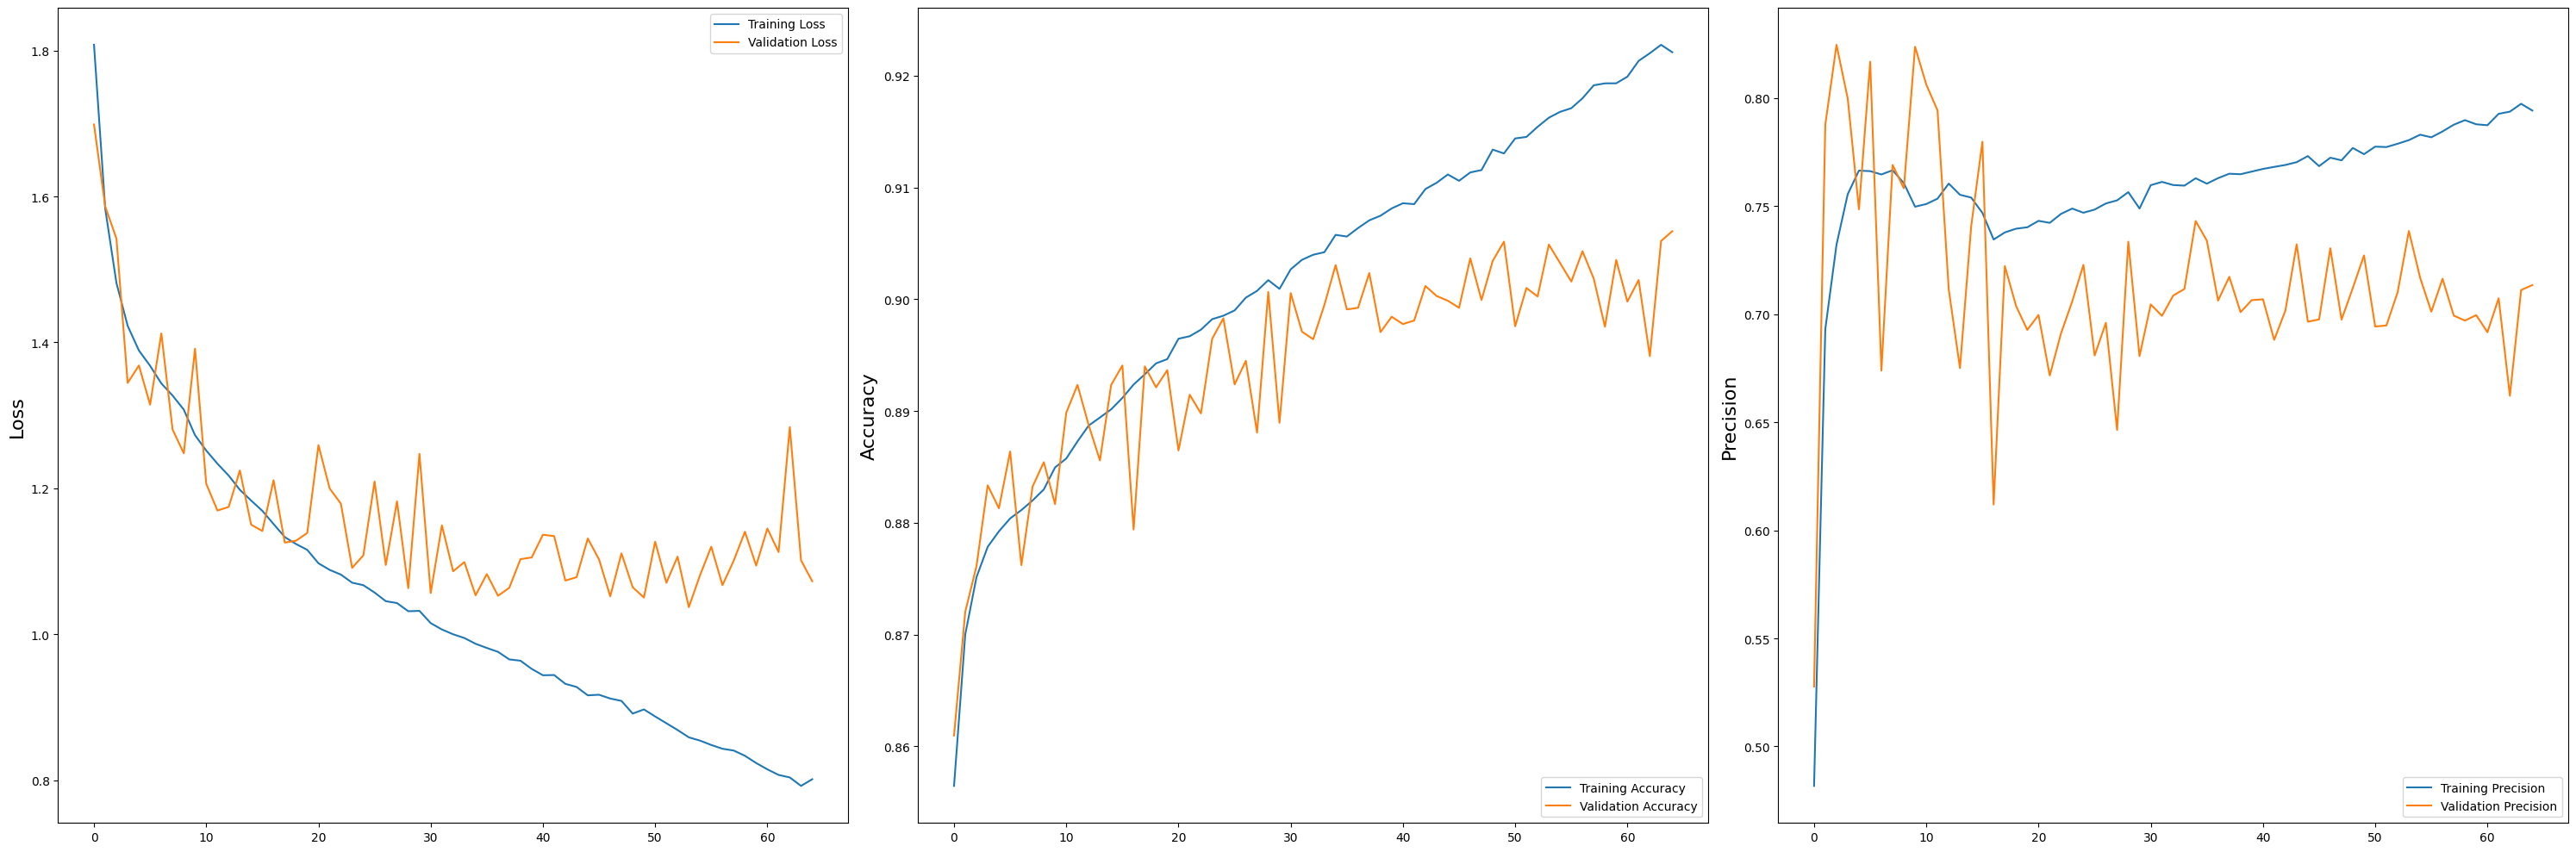

57/57 [==============================] - 6s 109ms/step
Classification report
              precision    recall  f1-score   support

           0       0.51      0.62      0.56       958
           1       0.63      0.53      0.58       111
           2       0.55      0.43      0.49      1024
           3       0.80      0.89      0.84      1774
           4       0.55      0.67      0.61      1233
           5       0.61      0.36      0.46      1247
           6       0.73      0.78      0.76       831

    accuracy                           0.64      7178
   macro avg       0.63      0.61      0.61      7178
weighted avg       0.64      0.64      0.63      7178

Model vgg saved at /kaggle/working/vgg
CPU times: user 2h 38min 22s, sys: 9min 16s, total: 2h 47min 39s
Wall time: 3h 11min 42s


In [12]:
%%time
### Model training Loop 

for model_name in models_config:
    model_instance = model_instances[model_name]

    for optimizer_name in models_config[model_name]:
        optimizer_class = optimizers_dict[optimizer_name]  # Get the optimizer class from the name
        for learning_rate in models_config[model_name][optimizer_name]:
            print(f"Model: {model_name}, Optimizer: {optimizer_name}, Learning Rate: {learning_rate}")

            # Call test_model with the model instance, optimizer class, and learning rate
            test_model(model_instance, optimizer_class, learning_rate, model_name, optimizer_name)

            # Export the model to /kaggle/working directory
            model_path = f'/kaggle/working/{model_name}'
            model_instance.save(model_path)
            print(f"Model {model_name} saved at {model_path}")

# Final Model Comparison

## Custom CNN Model Performance

- **Strengths**:
  - Exhibited balanced performance across most classes.
  - Notable proficiency in recognizing 'happy' (83% precision) and 'surprise' (75% precision).

- **Weaknesses**:
  - Struggled with 'disgust' and 'fear', potentially due to their similarity to other expressions and ambiguous labeling in the dataset.

- **Overall**:
  - Achieved an accuracy of 60%, more effective in clear-cut expressions like 'happy', less so in nuanced expressions.

## EfficientNetB0 Model Performance

- **Issue**:
  - The model did not train correctly, only able to classify 'happy'. Possible misalignment with dataset specifics or training parameters.

- **Result**:
  - Due to skewed performance, EfficientNetB0 is excluded from the final comparison.

## VGG Model Performance

- **Strengths**:
  - Performed well in identifying 'happy' (80% precision) and 'surprise' (73% precision).
  - Showed a good ability to distinguish 'neutral' expressions.

- **Weaknesses**:
  - Less effective in distinguishing 'sad' from other similar expressions, impacted by label ambiguities.

- **Overall**:
  - With an overall accuracy of 64%, the VGG model showed balanced performance but faced challenges in subtle or ambiguous categories.

## Final Comparison between Custom CNN and VGG Models

- The **Custom CNN Model** displayed strong recognition of distinct expressions like 'happy' and 'surprise', but faced difficulties in differentiating similar emotions like 'sad' versus 'neutral'.
- The **VGG Model** showed slightly higher overall accuracy and balance, particularly adept at identifying 'happy', 'surprise', and 'neutral' emotions.
- Both models demonstrate the complexity in facial expression recognition, particularly with subtle differences and ambiguous labels in datasets like FER2013. **Despite these challenges, VGG slightly outperforms the Custom CNN in overall accuracy and balance.**
This format uses bullet points, bold text for emphasis, and headings to clearly separate  and balance.








57/57 [==============================] - 6s 102ms/step


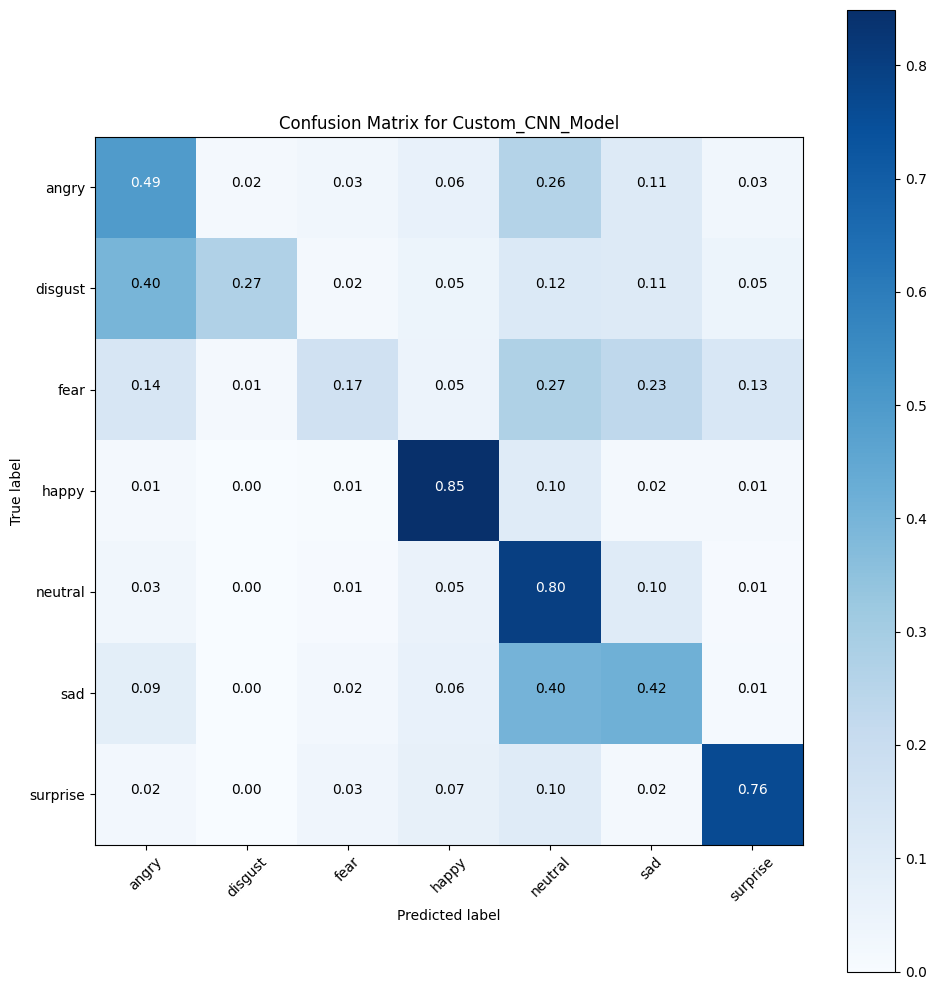

Classification Report for Custom_CNN_Model:
               precision    recall  f1-score   support

       angry       0.56      0.49      0.52       958
     disgust       0.43      0.27      0.33       111
        fear       0.62      0.17      0.26      1024
       happy       0.83      0.85      0.84      1774
     neutral       0.43      0.80      0.56      1233
         sad       0.50      0.42      0.45      1247
    surprise       0.75      0.76      0.75       831

    accuracy                           0.60      7178
   macro avg       0.59      0.54      0.53      7178
weighted avg       0.62      0.60      0.58      7178

57/57 [==============================] - 6s 100ms/step


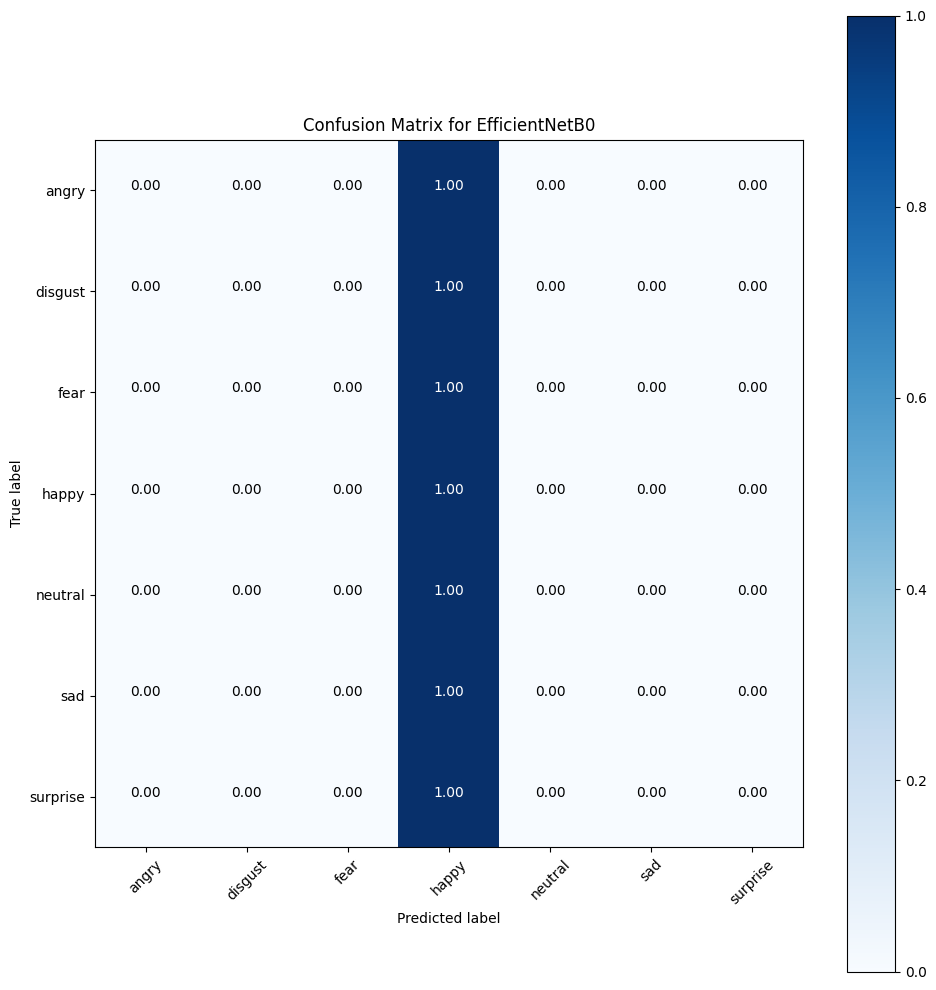

Classification Report for EfficientNetB0:
               precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.25      1.00      0.40      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.25      7178
   macro avg       0.04      0.14      0.06      7178
weighted avg       0.06      0.25      0.10      7178

57/57 [==============================] - 6s 111ms/step


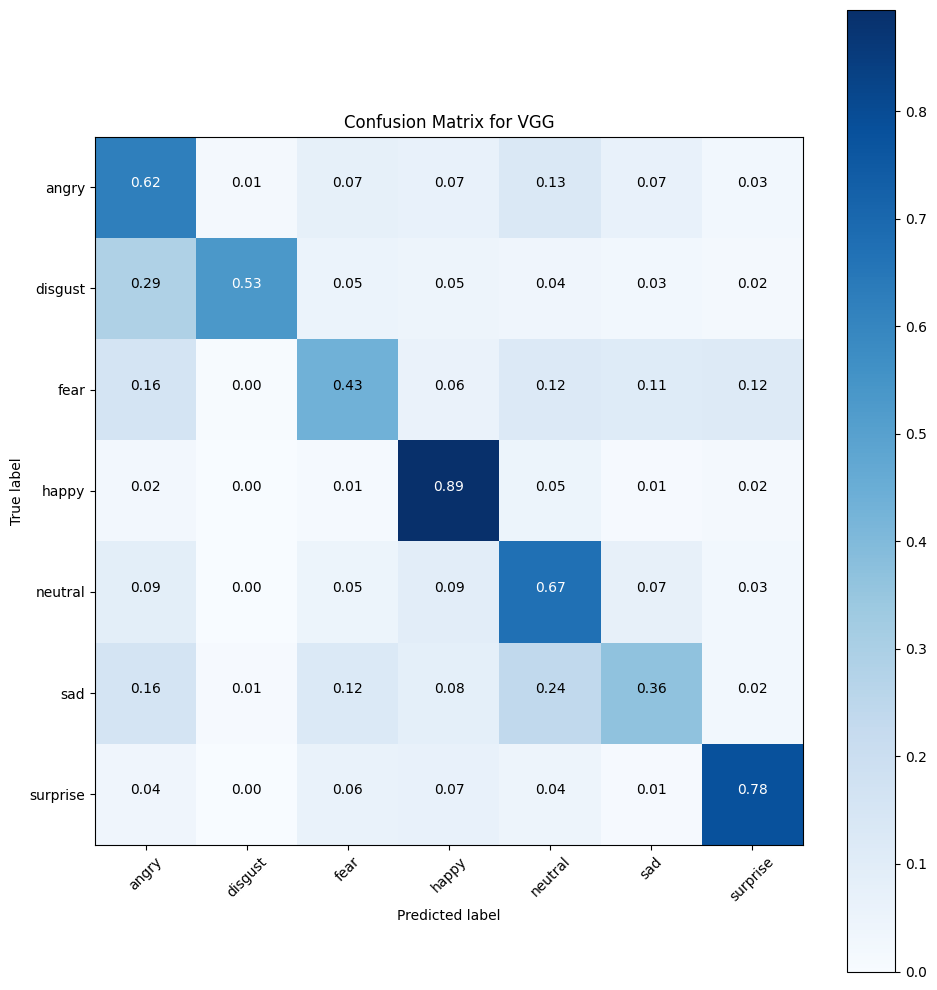

Classification Report for VGG:
               precision    recall  f1-score   support

       angry       0.51      0.62      0.56       958
     disgust       0.63      0.53      0.58       111
        fear       0.55      0.43      0.49      1024
       happy       0.80      0.89      0.84      1774
     neutral       0.55      0.67      0.61      1233
         sad       0.61      0.36      0.46      1247
    surprise       0.73      0.78      0.76       831

    accuracy                           0.64      7178
   macro avg       0.63      0.61      0.61      7178
weighted avg       0.64      0.64      0.63      7178



In [13]:
# Loop to compare models with classification report and CM 
for model_name, model in model_instances.items():
    generate_reports(model, testset)  

In [14]:
# Loading models after reopening the notebook 

# model_paths = {
#      'cnn': '/kaggle/working/cnn',
#      'cnn_2': '/kaggle/working/cnn_2',
#      'eb0': '/kaggle/working/eb0',
#      'eb0_2': '/kaggle/working/eb0_2',
#      'eb3': '/kaggle/working/eb3',
#      'eb3_2': '/kaggle/working/eb3_2'
#      'vgg': '/kaggle/working/vgg',
#      'vgg_2': '/kaggle/working/vgg_2'
# }

# loaded_models = {}
# for model_name, model_path in model_paths.items():
#     loaded_models[model_name] = load_model(model_path, custom_objects={'F1Score': F1Score})
#     print(f"Loaded model {model_name} from {model_path}")
    
    
# Loop to compare models with classification report and CM
# for model_name, model in loaded_models.items():
#     generate_reports(model, testset)  

# Model Visual Predictions

In our facial expression recognition project, we've encountered a significant challenge with the FER2013 dataset: some labels are ambiguous and inherently difficult to distinguish, a difficulty that is compounded by the human inability to consistently recognize these subtle differences. Emotions like 'sad' versus 'neutral', or 'angry' versus 'disgust', can often appear very similar, blurring the lines for clear categorization. This issue persists even in the FER2013Plus dataset, a cleaner and refined version of the original. These ambiguities highlight the complex nature of human facial expressions and the challenges they pose for accurate computational recognition and classification.

## Custom CN


CNN vs Testset
4/4 [==============================] - 1s 5ms/step
Correct prediction: 0.546875


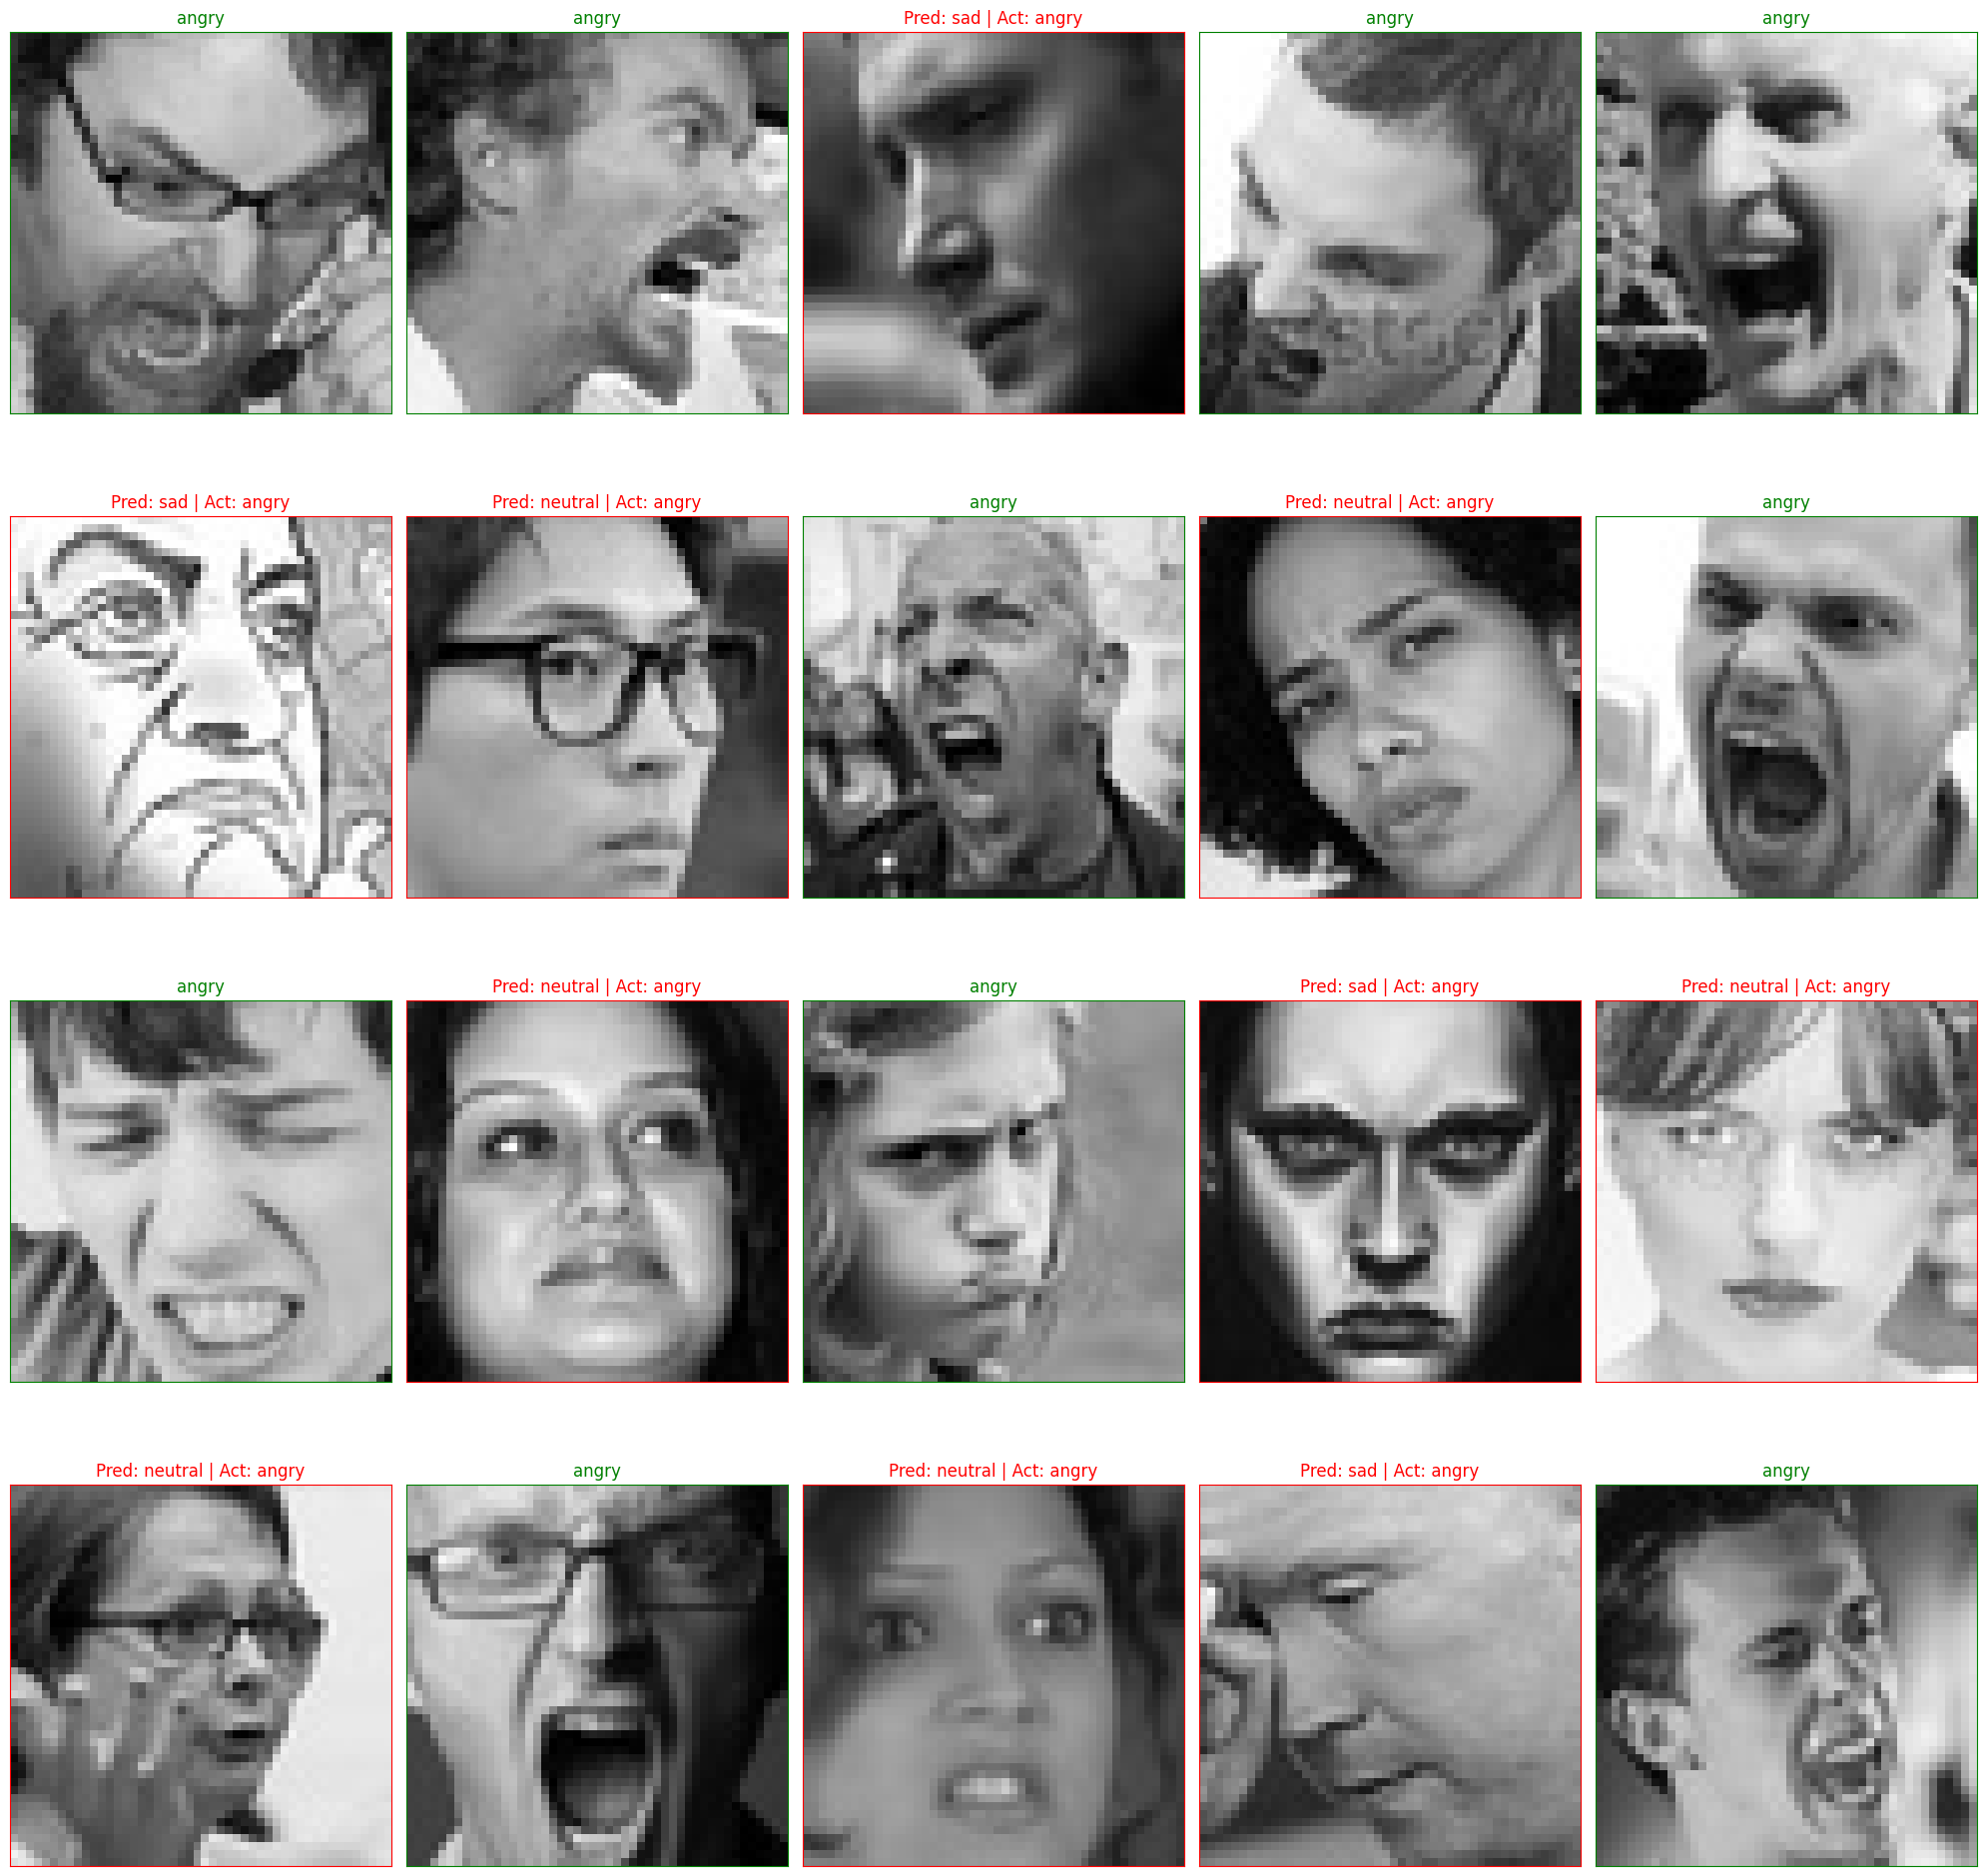

In [15]:
print("CNN vs Testset")
display_predictions(cnn, testset)

CNN vs Testset_shuffled
4/4 [==============================] - 0s 6ms/step
Correct prediction: 0.609375


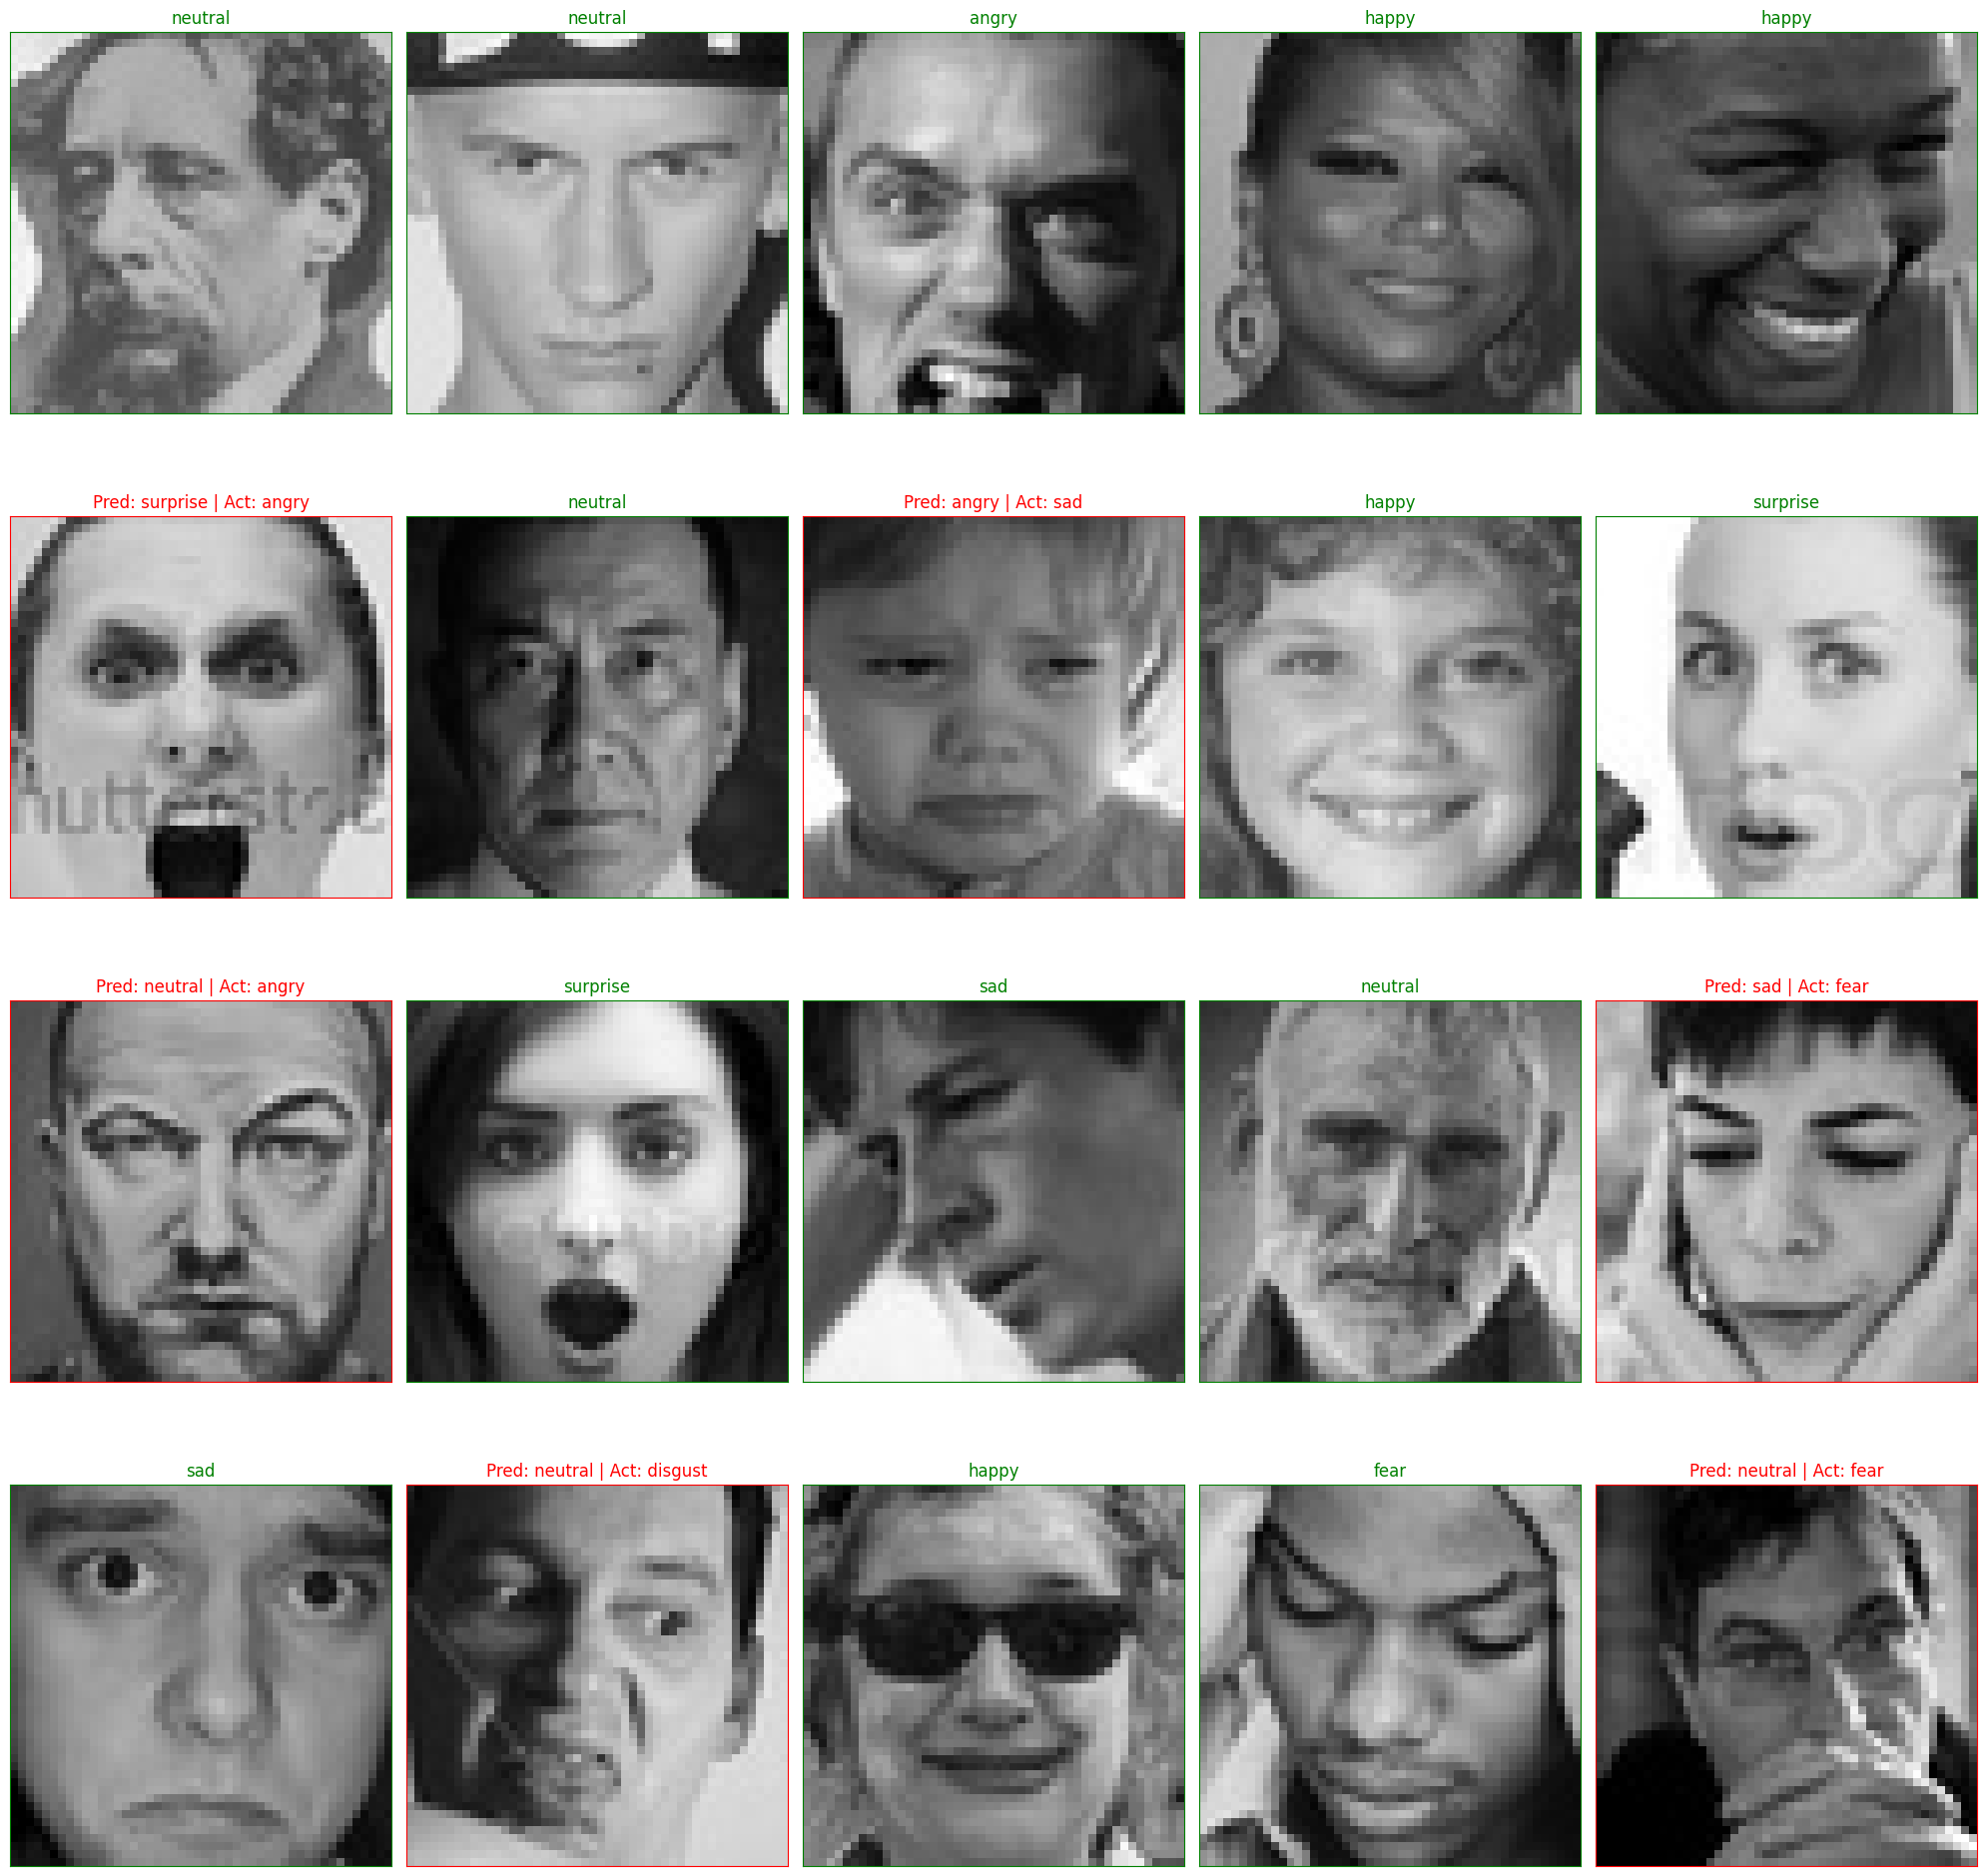

In [17]:
print("CNN vs Testset_shuffled")
display_predictions(cnn, testset_shuffled)

CNN vs Testset_Ferplus
4/4 [==============================] - 0s 6ms/step
Correct prediction: 0.578125


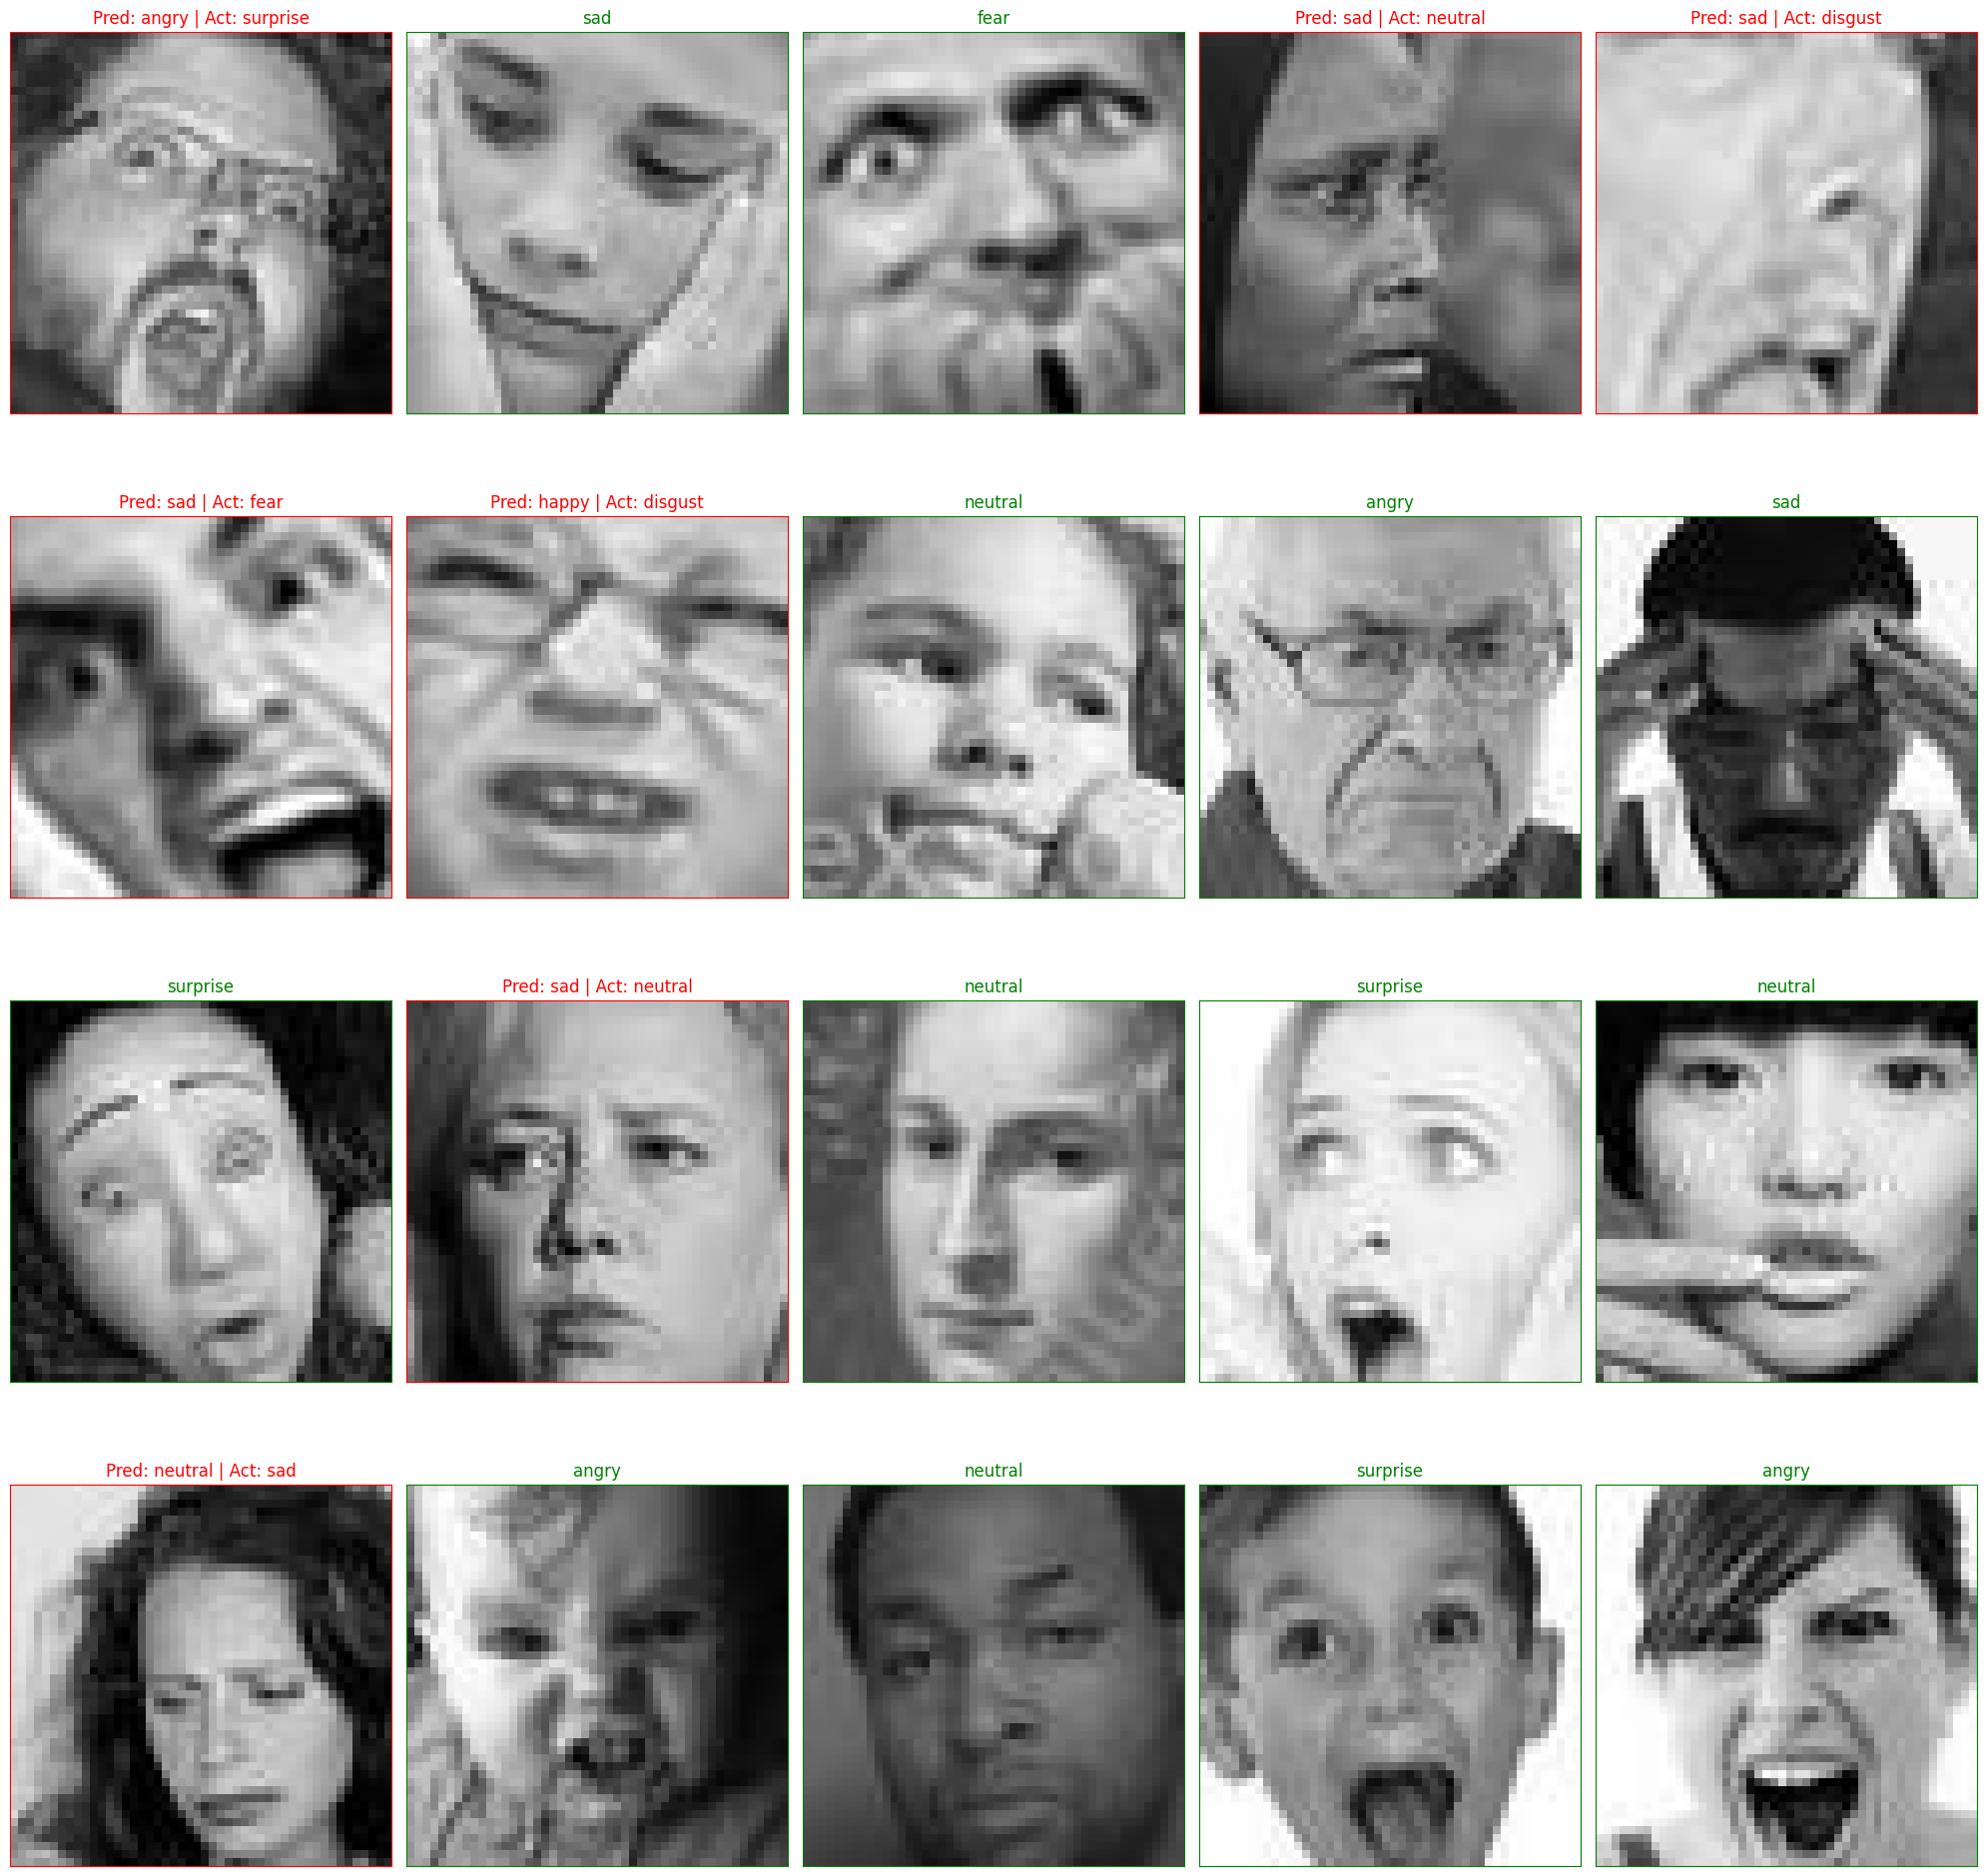

In [19]:
print("CNN vs Testset_Ferplus")
display_predictions(cnn, testset_ferplus)

## EfficientNet B0

**As the model did not train correctly - the results are omitted.**

## VGG

VGG vs Testset
4/4 [==============================] - 1s 9ms/step
Correct prediction: 0.65625


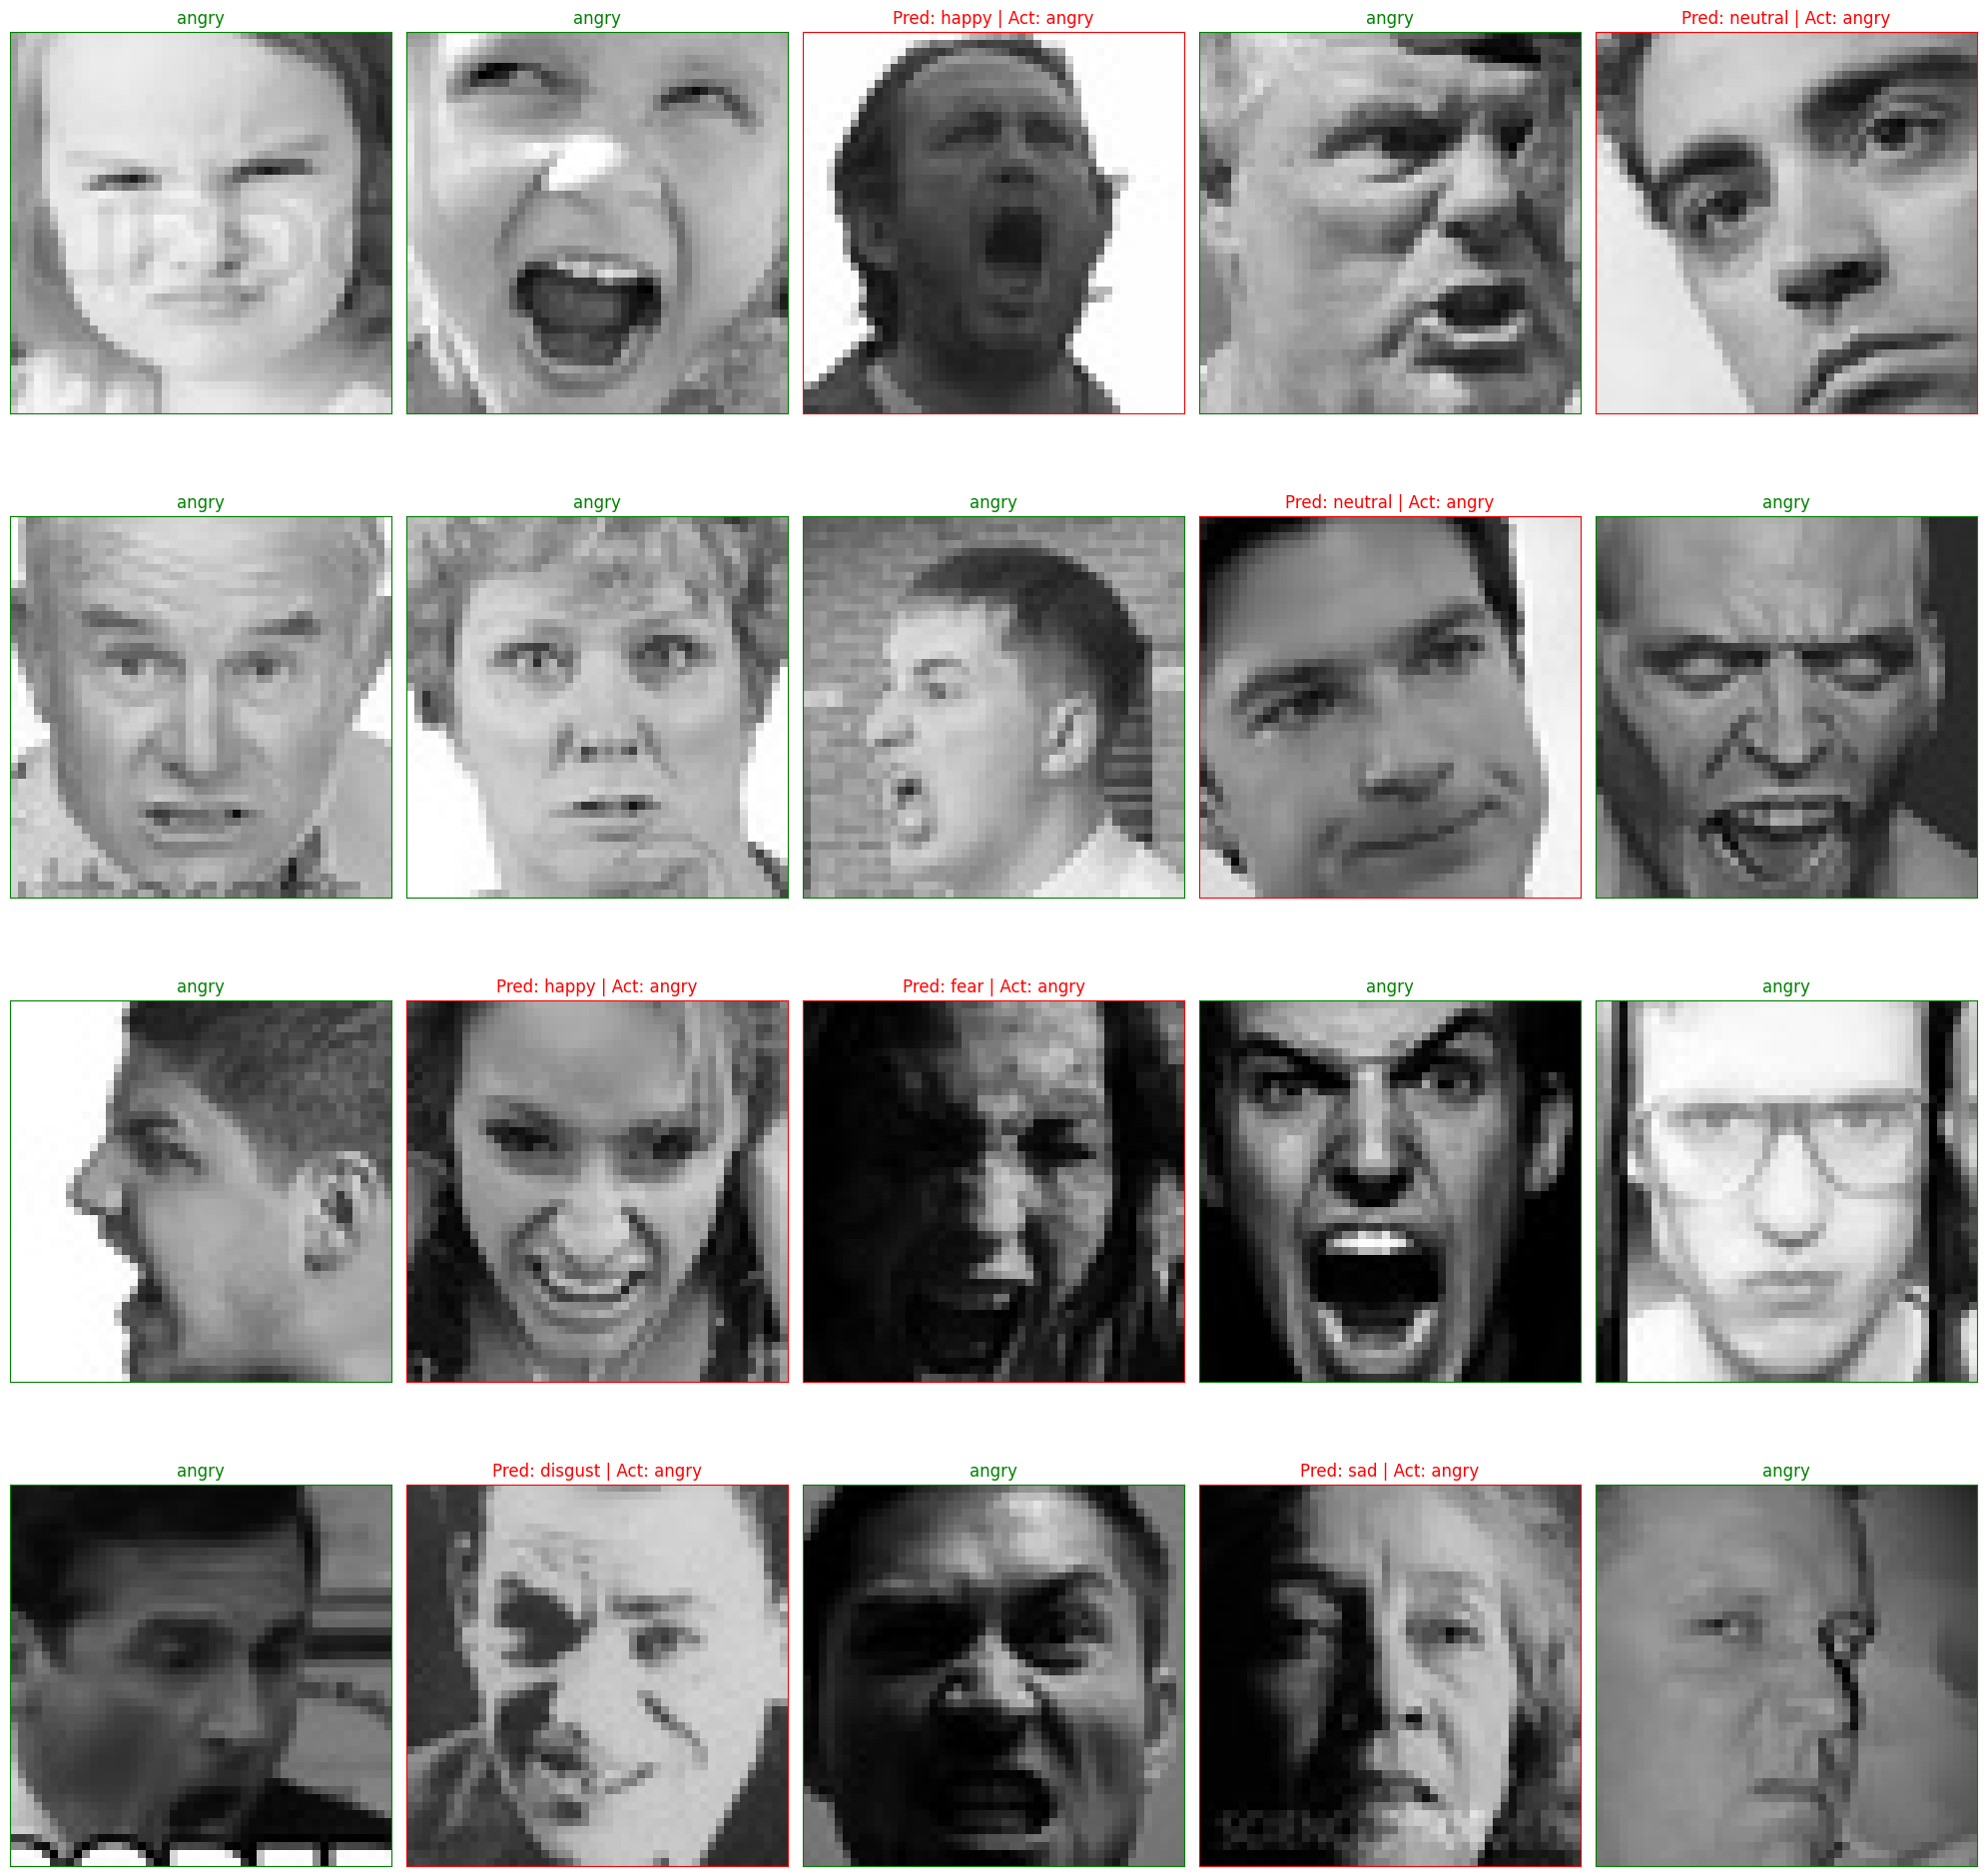

In [29]:
print("VGG vs Testset")
display_predictions(vgg, testset)

VGG vs Testset_shuffled
4/4 [==============================] - 0s 15ms/step
Correct prediction: 0.734375


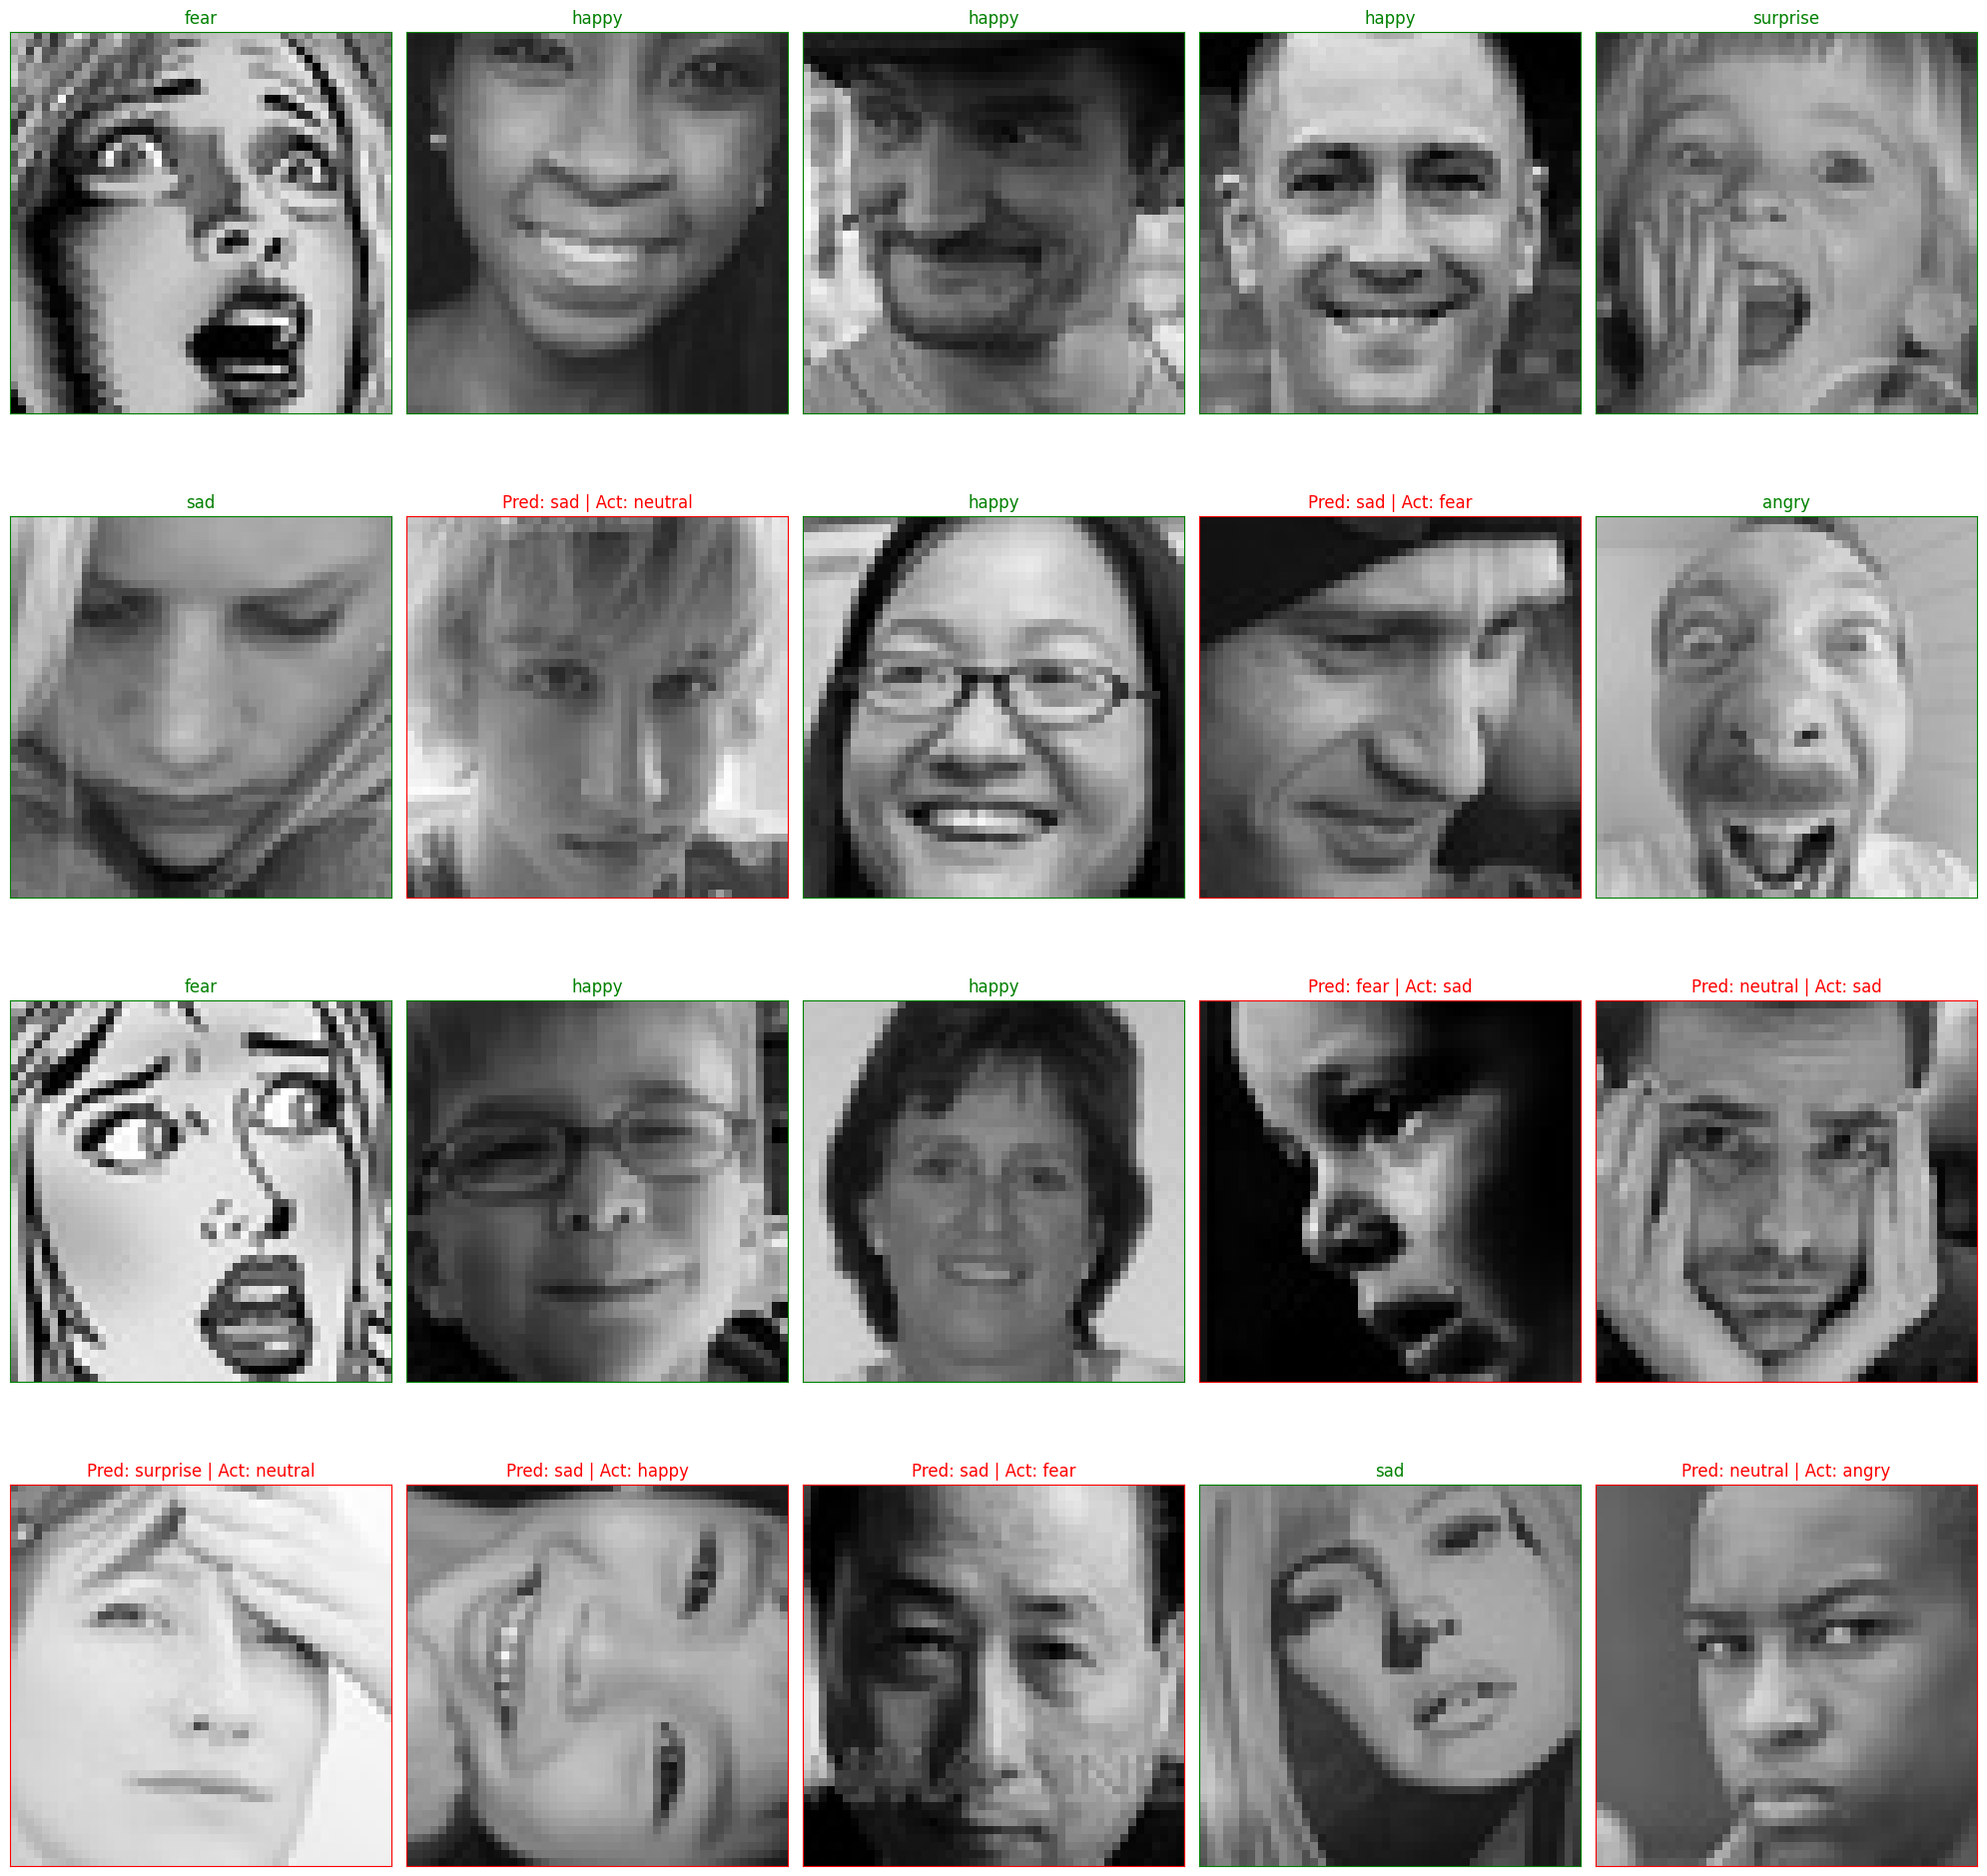

In [32]:
print("VGG vs Testset_shuffled")
display_predictions(vgg, testset_shuffled)

VGG vs Testset_Ferplus
4/4 [==============================] - 0s 15ms/step
Correct prediction: 0.6171875


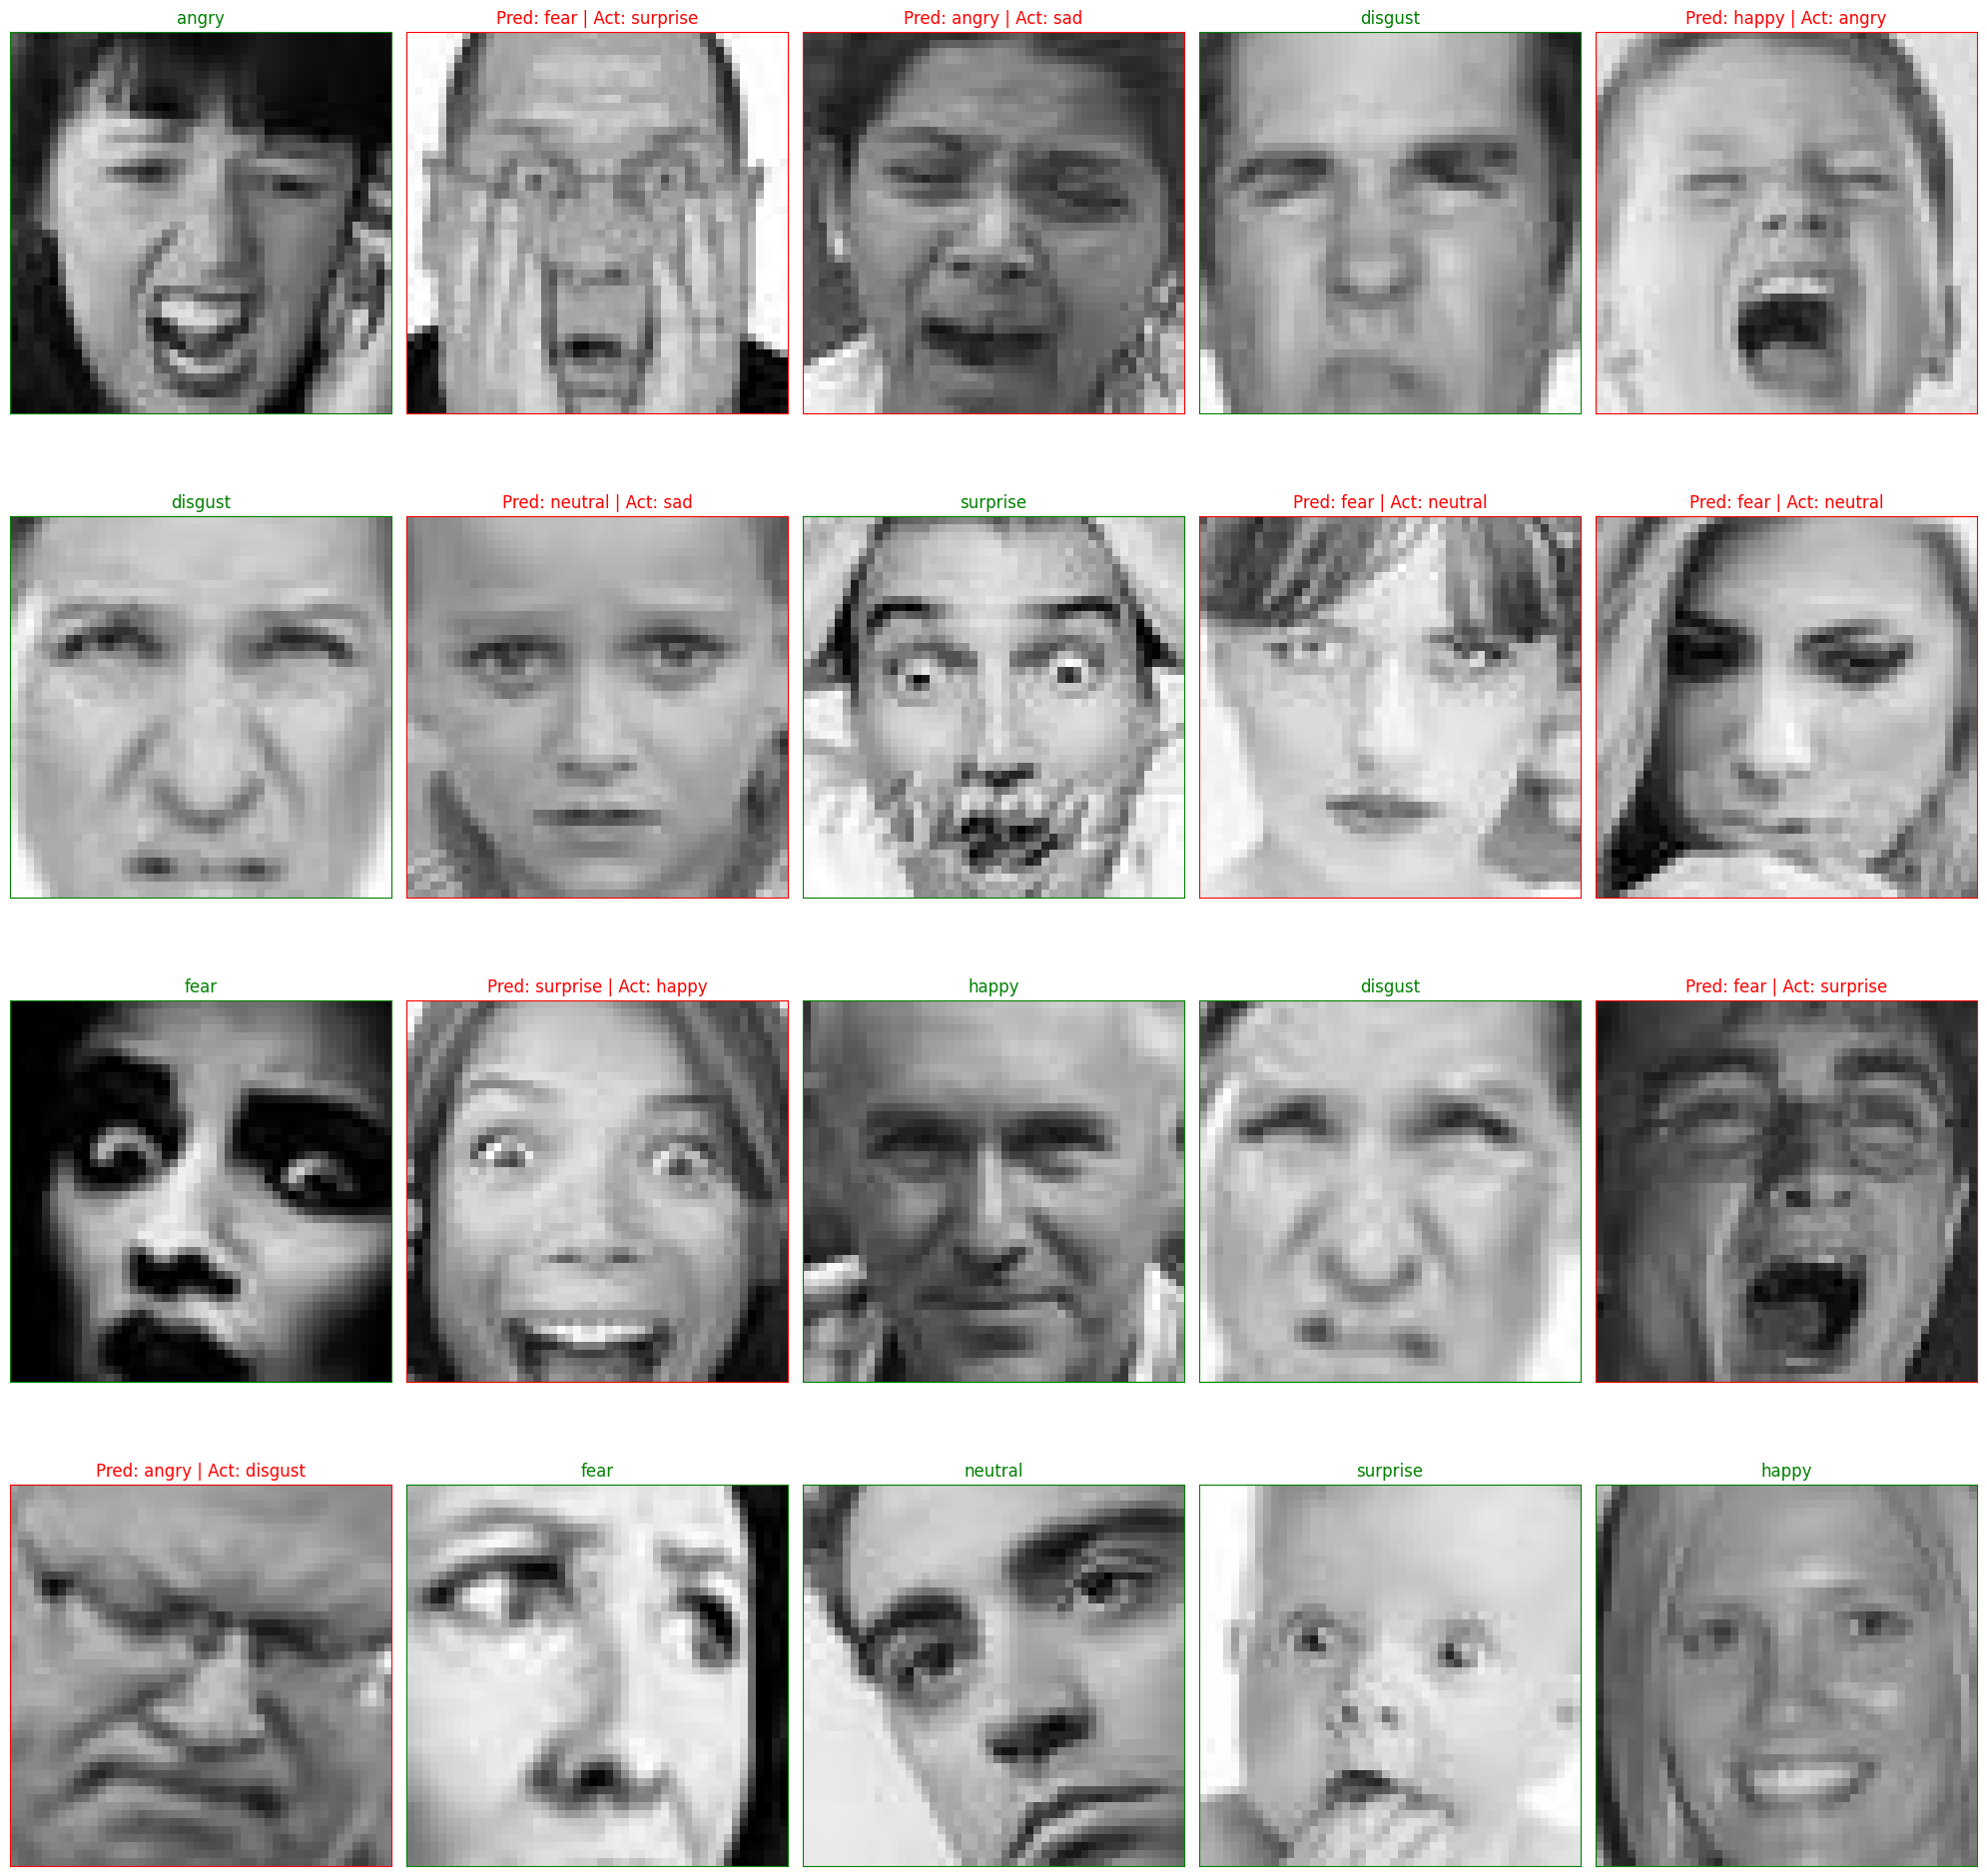

In [34]:
print("VGG vs Testset_Ferplus")
display_predictions(vgg, testset_ferplus)